In [2]:
import warnings
warnings.filterwarnings("ignore")

### basic datatype libraries
import numpy.ma as ma
import pandas as pd
import numpy as np
from scipy import interpolate
import itertools
import random
import math

### Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

### machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.distributions import Normal

### this library is edited and imported from the shap-master folder
import shap

### widgets and process bars
from tqdm.notebook import tqdm

### date and time libraries
from datetime import timedelta, date, datetime
from IPython.display import clear_output

In [3]:
!nvidia-smi

Mon Aug 26 09:09:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:65:00.0 Off |                    0 |
| N/A   30C    P0             45W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
# Set the memory limit on the GPU
device_no = 1
device = torch.device(f"cuda:{device_no}" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

# Data Preprocessing

In [39]:
def interpolate_nan(data):
    interpolated_data = np.copy(data)
    
    # Define a function to find nearest non-NaN values
    def nearest_non_nan(ix, iy, iz, data):
        for offset in itertools.count(start=1, step=1):
            slices = np.s_[max(0, ix - offset):min(data.shape[0], ix + offset + 1),
                           max(0, iy - offset):min(data.shape[1], iy + offset + 1),
                           max(0, iz - offset):min(data.shape[2], iz + offset + 1)]
            
            sub_array = data[slices]
            if not np.isnan(sub_array).all():
                return np.nanmean(sub_array)
        return np.nan
    
    nan_positions = np.argwhere(np.isnan(data))
    
    for t, lat, lon in nan_positions:
        
        # Spatial Interpolation
        spatial_val = nearest_non_nan(t, lat, lon, data)
        
        # Temporal Interpolation
        temporal_vals = []
        if t > 0: 
            temporal_vals.append(interpolated_data[t - 1, lat, lon])
        if t < data.shape[0] - 1:
            temporal_vals.append(interpolated_data[t + 1, lat, lon])
        
        # Seasonal Interpolation
        seasonal_vals = []
        if t >= 12:
            seasonal_vals.extend([interpolated_data[t - 12, lat, lon],
                                  interpolated_data[t - 13, lat, lon] if t - 13 >= 0 else np.nan,
                                  interpolated_data[t - 11, lat, lon] if t - 11 < data.shape[0] else np.nan])
        
        # Combine obtained values to interpolate the NaN value
        non_nan_vals = [val for val in [spatial_val, *temporal_vals, *seasonal_vals] if not np.isnan(val)]
        interpolated_data[t, lat, lon] = np.mean(non_nan_vals) if non_nan_vals else np.nan
    
    return interpolated_data

def deseasonalize(data):
    ### to calculate the data anomaly
    n_years = int(data.shape[0]/12)
    data_mean = np.nanmean(data.reshape(n_years, 12, data.shape[1], data.shape[2]), axis = 0, keepdims=True)
    climatology = np.repeat(data_mean, n_years, axis = 0).reshape(n_years*12, data.shape[1], data.shape[2])
    data_deseasonalize = (data.reshape(n_years, 12, data.shape[1], data.shape[2]) - data_mean) ## substract monthly means from all years
    data_deseasonalize = data_deseasonalize.reshape(n_years*12, data.shape[1], data.shape[2])
    return data_deseasonalize, climatology

def calculate_anomaly(data, percentage):
    ### to calculate the data anomaly
    n_years = int(data.shape[0]/12)
    data = data.reshape(n_years, 12, data.shape[1], data.shape[2])
    
    # Calculate the median along the years axis and the deviations from the median.
    median = np.median(data, axis=0)
    deviations = data - median

    # Calculate the percentile of the absolute deviations along the years axis.
    threshold = np.percentile(np.abs(deviations), percentage, axis=0)

    # Create an anomaly array: wherever the absolute deviation is greater than the threshold, 
    # it contains the deviation from the median; otherwise, it contains 0.
    data_anomaly = np.where(np.abs(deviations) > threshold, deviations, 0)
    data_anomaly = data_anomaly.reshape(n_years*12, data_anomaly.shape[2], data_anomaly.shape[3])
    
    return data_anomaly

In [65]:
region = 'Equatorial' ## Temperate, Tropical, Equatorial
data = np.load(f'.../{region}.npy')
variables = np.array(['CHL', 'mlotst', 'oc', 'adt', 'sos', 'sst', 'WS', 'WSC'])

print(variables, data.shape)

['CHL' 'mlotst' 'oc' 'adt' 'sos' 'sst' 'WS' 'WSC'] (8, 228, 38, 84)


In [ ]:
data1 = data.copy()
interpolated_data = np.empty_like(data1)
with tqdm(total=len(data1)) as pbar:
    for i, dd in enumerate(data1):
        if isweekly == False:
            interpolated_data[i] = interpolate_nan(dd)
        else:
            interpolated_data[i] = interpolate_nan_weekly(dd)
        pbar.update(1)

### taking log of bio variables
interpolated_data[0] = np.log10(interpolated_data[0])

percentage = 90
data_deseasonalize = np.empty_like(interpolated_data)
climatology_data = np.empty_like(data1)

with tqdm(total=len(interpolated_data)) as pbar:
    for i in range(interpolated_data.shape[0]):
        if isweekly == False:
            data_deseasonalize[i], climatology_data[i] = deseasonalize(interpolated_data[i])
        else:
            data_deseasonalize[i] = deseasonalize_weekly_data(interpolated_data[i])
        pbar.update(1)

time_array = pd.date_range('01-01-2003', '31-12-2021', freq = 'M').to_numpy()
time_array = np.reshape(time_array, (1, 228, 1, 1))

In [74]:
class DataPreprocessing:
    
    def __init__(self):
        return
    
    def make_chunks(self, data, chunk_size): 
        chunks = []
    
        # Iterate over the data to create chunks
        for i in range(0, data.shape[2], chunk_size[0]):
            for j in range(0, data.shape[3], chunk_size[1]):
                chunk = data[:, :, i:i + chunk_size[0], j:j + chunk_size[1]]
                chunk = chunk.reshape(chunk.shape[0], chunk.shape[1], -1)
                chunks.append(chunk)
    
        chunks = np.concatenate(chunks, axis = 2)
        return chunks
        
    def split_data(self, interpolated_data, data_deseasonalize, climatology_data, time_array, batch_size, train_ratio, validation_ratio, test_ratio): ### this will take all kinds of data and split them into training, validation and test

        is_chunk_data = False
        if is_chunk_data == True:
            chunk_size = (10, 20)
            input_data1 = self.make_chunks(data_deseasonalize, chunk_size)
            input_data2 = self.make_chunks(interpolated_data, chunk_size)
            clim_data = self.make_chunks(climatology_data, chunk_size).swapaxes(0,2)
            input_data = np.append(input_data1, input_data2, axis = 0).swapaxes(0,2)
    
        else:
            ### selected parameters
            input_data1 = data_deseasonalize.reshape(data_deseasonalize.shape[0], data_deseasonalize.shape[1], -1)
            input_data2 = interpolated_data.reshape(interpolated_data.shape[0], interpolated_data.shape[1], -1)
            input_data = np.append(input_data1, input_data2, axis = 0).swapaxes(0,2)
            clim_data = climatology_data.reshape(climatology_data.shape[0], climatology_data.shape[1], -1).swapaxes(0,2)
            time_data = time_array.reshape(time_array.shape[0], time_array.shape[1], -1).swapaxes(0,2)
    
        # Calculate the number of full batches and the size of the last batch
        num_full_batches = input_data.shape[1] // batch_size
        last_batch_size = input_data.shape[1] % batch_size
        
        batches = []
        clim_batches = []
        time_batches = []
        
        for i in range(num_full_batches):
            batch = input_data[:, i * batch_size:(i + 1) * batch_size, :]
            batches.append(batch)
            
            batch = clim_data[:, i * batch_size:(i + 1) * batch_size, :]
            clim_batches.append(batch)
            
            batch = time_data[:, i * batch_size:(i + 1) * batch_size, :]
            time_batches.append(batch)
        
        # combine the last batch
        if last_batch_size > 0:
            batches[-1] = np.concatenate((batches[-1], input_data[:, -last_batch_size:, :]), axis=1)
            clim_batches[-1] = np.concatenate((clim_batches[-1], clim_data[:, -last_batch_size:, :]), axis=1)
            time_batches[-1] = np.concatenate((time_batches[-1], time_data[:, -last_batch_size:, :]), axis=1)

        # Calculate 70% of the array length
        num_elements_80_percent = int(len(batches) * train_ratio)
        train_indices = np.random.choice(len(batches), num_elements_80_percent, replace=False)
        remaining_indices = np.setdiff1d(np.arange(len(batches)), train_indices)
        
        np.random.shuffle(remaining_indices)
        np.random.seed(7)
        split_index = len(remaining_indices) // 2
        valid_indices = remaining_indices[:split_index]
        test_indices = remaining_indices[split_index:]
        
        X_train = []; X_val = []; X_test = []
        X_train_clim = []; X_val_clim = []; X_test_clim = []
        X_train_time = []; X_val_time = []; X_test_time = []
        
        for i in np.sort(train_indices):
            X_train.append(batches[i])
            X_train_clim.append(clim_batches[i])
            X_train_time.append(time_batches[i])
        
        for i in np.sort(valid_indices):
            X_val.append(batches[i])
            X_val_clim.append(clim_batches[i])
            X_val_time.append(time_batches[i])
        
        for i in np.sort(test_indices):
            X_test.append(batches[i])
            X_test_clim.append(clim_batches[i])
            X_test_time.append(time_batches[i])

        return X_train, X_train_clim, X_train_time, X_val, X_val_clim, X_val_time, X_test, X_test_clim, X_test_time

    def split_sequences(self, sequences, n_steps_in, n_steps_out, overlap, bio_var, phy_var):

        step_size = n_steps_in - overlap
        X1, X2, y = list(), list(), list()
    
        for i in range(0, len(sequences[0]) - n_steps_in - n_steps_out + 1, step_size):  # Iterating over time series length
    
            if phy_var == None: ## only in the case where I am creating splits for time
                seq_x1 = None
                seq_x2 = None
    
            else:
                ## taking all variables in input + taking phy var from future
                seq_x1 = sequences[:, i:i + n_steps_in, :]
                seq_x2 = sequences[:, i + n_steps_in:i + n_steps_in + n_steps_out, phy_var]
                
            # Taking only bio variables as output
            seq_y = sequences[:, i + n_steps_in:i + n_steps_in + n_steps_out, bio_var] 
    
            X1.append(seq_x1)
            X2.append(seq_x2)
            y.append(seq_y)
    
        if phy_var == None:
            y = np.swapaxes(np.array(y), 0, 1)
            return y
    
        else:   
            X1 = np.swapaxes(np.array(X1), 0, 1)
            X2 = np.swapaxes(np.array(X2), 0, 1)
            y = np.swapaxes(np.array(y), 0, 1)
            
        return X1, X2, y

    def scale_dataset(self, X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test):
        
        scaler_X1 = MinMaxScaler() # MinMaxScaler() StandardScaler()
        scaler_X2 = MinMaxScaler() # MinMaxScaler() StandardScaler()
        scaler_y = MinMaxScaler() # MinMaxScaler() StandardScaler()
        
        ## To avoid data leakage, fit is only applied on train data
        X1_train = scaler_X1.fit_transform(X1_train.reshape(-1, X1_train.shape[3])).reshape(X1_train.shape)
        X2_train = scaler_X2.fit_transform(X2_train.reshape(-1, X2_train.shape[3])).reshape(X2_train.shape)
        y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[3])).reshape(y_train.shape)
        
        X1_val = scaler_X1.transform(X1_val.reshape(-1, X1_val.shape[3])).reshape(X1_val.shape)
        X2_val = scaler_X2.transform(X2_val.reshape(-1, X2_val.shape[3])).reshape(X2_val.shape)
        y_val = scaler_y.transform(y_val.reshape(-1, y_val.shape[3])).reshape(y_val.shape)
        
        X1_test = scaler_X1.transform(X1_test.reshape(-1, X1_test.shape[3])).reshape(X1_test.shape)
        X2_test = scaler_X2.transform(X2_test.reshape(-1, X2_test.shape[3])).reshape(X2_test.shape)
        y_test = scaler_y.transform(y_test.reshape(-1, y_test.shape[3])).reshape(y_test.shape)

        return X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test, scaler_y

    def merge_phy_chl(self, X1_train, X2_train, X1_val, X2_val, X1_test, X2_test, data_shape):

        #################################################
        # merge current phy+chl-a and future physical variables
        #################################################
        X1_train_physical_vars =  np.concatenate([X1_train[:, :, :, 1:8], X1_train[:, :, :, 9:]], axis = -1)  # (samples, timesteps, physical variables)
        X1_train_bio_vars_1 = np.expand_dims(X1_train[:, :, :, 0], axis=-1)  # to keep the last dim
        X1_train_bio_vars_2 = np.expand_dims(X1_train[:, :, :, 8], axis=-1)  # to keep the last dim
        X1_train_bio_vars = np.concatenate([X1_train_bio_vars_1, X1_train_bio_vars_2], axis = -1)
        # Concatenate current physical variables with future physical variables
        combined_train_physical_vars = np.concatenate([X1_train_physical_vars, X2_train], axis=2)  # (samples, timesteps*2, physical variables)
        
        X1_val_physical_vars =  np.concatenate([X1_val[:, :, :, 1:8], X1_val[:, :, :, 9:]], axis = -1)  # (samples, timesteps, physical variables)
        X1_val_bio_vars_1 = np.expand_dims(X1_val[:, :, :, 0], axis=-1)  # to keep the last dim
        X1_val_bio_vars_2 = np.expand_dims(X1_val[:, :, :, 8], axis=-1)  # to keep the last dim
        X1_val_bio_vars = np.concatenate([X1_val_bio_vars_1, X1_val_bio_vars_2], axis = -1)
        # Concatenate current physical variables with future physical variables
        combined_val_physical_vars = np.concatenate([X1_val_physical_vars, X2_val], axis=2)  # (samples, timesteps*2, physical variables)
        
        X1_test_physical_vars =  np.concatenate([X1_test[:, :, :, 1:8], X1_test[:, :, :, 9:]], axis = -1)  # (samples, timesteps, physical variables)
        X1_test_bio_vars_1 = np.expand_dims(X1_test[:, :, :, 0], axis=-1)  # to keep the last dim
        X1_test_bio_vars_2 = np.expand_dims(X1_test[:, :, :, 8], axis=-1)  # to keep the last dim
        X1_test_bio_vars = np.concatenate([X1_test_bio_vars_1, X1_test_bio_vars_2], axis = -1)
        
        # Concatenate current physical variables with future physical variables
        combined_test_physical_vars = np.concatenate([X1_test_physical_vars, X2_test], axis=2)  # (samples, timesteps*2, physical variables)
        
        # Initialize separate arrays for physical and bio variables
        X_train_physical = np.full((data_shape['n_samples'], data_shape['n_seq_train'], data_shape['n_ip_timesteps'], 14), -1.0)
        X_train_bio = np.full((data_shape['n_samples'], data_shape['n_seq_train'], data_shape['n_ip_timesteps'], 2), -1.0)
        X_val_physical = np.full((data_shape['n_samples'], data_shape['n_seq_val'], data_shape['n_ip_timesteps'], 14), -1.0)
        X_val_bio = np.full((data_shape['n_samples'], data_shape['n_seq_val'], data_shape['n_ip_timesteps'], 2), -1.0)
        X_test_physical = np.full((data_shape['n_samples'], data_shape['n_seq_test'], data_shape['n_ip_timesteps'], 14), -1.0)
        X_test_bio = np.full((data_shape['n_samples'], data_shape['n_seq_test'], data_shape['n_ip_timesteps'], 2), -1.0)

        
        ## combine phy and chl
        X_train_physical = combined_train_physical_vars
        X_train_bio[:, :, :n_steps_in, :] = X1_train_bio_vars
        X_train = np.concatenate([X_train_physical, X_train_bio], axis=-1)
        
        X_val_physical = combined_val_physical_vars
        X_val_bio[:, :, :n_steps_in, :] = X1_val_bio_vars
        X_val = np.concatenate([X_val_physical, X_val_bio], axis=-1)
        
        X_test_physical = combined_test_physical_vars
        X_test_bio[:, :, :n_steps_in, :] = X1_test_bio_vars
        X_test = np.concatenate([X_test_physical, X_test_bio], axis=-1)
        
        return X_train, X_val, X_test

    def add_lat_lon(self, X_train, X_val, X_test, data_shape):

        #################################################
        ### add the lat and lon in the data for SPG shape 
        ### and scale it as well to append with scaled data
        #################################################
        lat = np.arange(50, 60, 0.25); lon = np.arange(-40, -20, 0.25)
        lon_mesh = np.meshgrid(lon,lat)[0].flatten(); lat_mesh = np.meshgrid(lon,lat)[1].flatten()
        
        # Reshape lat and lon to (3200, 1, 1, 1)
        lat_expanded = lat_mesh.reshape(-1, 1, 1, 1); lon_expanded = lon_mesh.reshape(-1, 1, 1, 1)
        
        # Repeat lat and lon across the dimensions to match the shape
        lat_train = np.repeat(lat_expanded, data_shape['n_seq_train'], axis=1)
        lat_train = np.repeat(lat_train, data_shape['n_ip_timesteps'], axis=2)
        lon_train = np.repeat(lon_expanded, data_shape['n_seq_train'], axis=1)
        lon_train = np.repeat(lon_train, data_shape['n_ip_timesteps'], axis=2)
        
        lat_val = np.repeat(lat_expanded, data_shape['n_seq_val'], axis=1)
        lat_val = np.repeat(lat_val, data_shape['n_ip_timesteps'], axis=2)
        lon_val = np.repeat(lon_expanded, data_shape['n_seq_val'], axis=1)
        lon_val = np.repeat(lon_val, data_shape['n_ip_timesteps'], axis=2)
        
        lat_test = np.repeat(lat_expanded, data_shape['n_seq_test'], axis=1)
        lat_test = np.repeat(lat_test, data_shape['n_ip_timesteps'], axis=2)
        lon_test = np.repeat(lon_expanded, data_shape['n_seq_test'], axis=1)
        lon_test = np.repeat(lon_test, data_shape['n_ip_timesteps'], axis=2)
        
        ## scale lat and lon
        scaler_lat = MinMaxScaler()
        scaler_lon = MinMaxScaler()
        
        ## To avoid data leakage, fit is only applied on train data
        lat_train = scaler_lat.fit_transform(lat_train.reshape(-1, lat_train.shape[3])).reshape(lat_train.shape)
        lat_val = scaler_lat.transform(lat_val.reshape(-1, lat_val.shape[3])).reshape(lat_val.shape)
        lat_test = scaler_lat.transform(lat_test.reshape(-1, lat_test.shape[3])).reshape(lat_test.shape)
        
        ## To avoid data leakage, fit is only applied on train data
        lon_train = scaler_lon.fit_transform(lon_train.reshape(-1, lon_train.shape[3])).reshape(lon_train.shape)
        lon_val = scaler_lon.transform(lon_val.reshape(-1, lon_val.shape[3])).reshape(lon_val.shape)
        lon_test = scaler_lon.transform(lon_test.reshape(-1, lon_test.shape[3])).reshape(lon_test.shape)
        
        X_train = np.concatenate([X_train, lat_train, lon_train], axis=3)
        X_val = np.concatenate([X_val, lat_val, lon_val], axis=3)
        X_test = np.concatenate([X_test, lat_test, lon_test], axis=3)
        
        ## Update input variables now because we added lat and lon
        data_shape['n_ip_var'] = X_train.shape[3]

        return X_train, X_val, X_test, data_shape
        
    def prepare_data(self, X_train, X_train_clim, X_train_time, X_val, X_val_clim, X_val_time, X_test, X_test_clim, X_test_time, n_steps_in, n_steps_out, overlap, is_add_lat_lon):

        bio_var = (0, 8) #(0,8)
        phy_var = (1,2,3,4,5,6,7,9,10,11,12,13,14,15)
        bio_var_clim = (0)
        phy_var_clim = (1,2,3,4,5,6,7)

        bio_var_time = (0) ## actually just putting time here to have time for y
        phy_var_time = None

        X1_train = []; X2_train = []; y_train = []; X1_val = []; X2_val = []; y_val = []; X1_test = []; X2_test = []; y_test = []
        X1_train_clim = []; X2_train_clim = []; y_train_clim = []; X1_val_clim = []; X2_val_clim = []; y_val_clim = []; X1_test_clim = []; X2_test_clim = []; y_test_clim = []
        X1_train_time = []; X2_train_time = []; y_train_time = []; X1_val_time = []; X2_val_time = []; y_val_time = []; X1_test_time = []; X2_test_time = []; y_test_time = []
        
        for data, data1, t in zip(X_train, X_train_clim, X_train_time):
            X1, X2, y = self.split_sequences(data, n_steps_in, n_steps_out, overlap, bio_var, phy_var)
            X1_train.append(X1); X2_train.append(X2); y_train.append(y)
        
            X1, X2, y = self.split_sequences(data1, n_steps_in, n_steps_out, overlap, bio_var_clim, phy_var_clim)
            X1_train_clim.append(X1); X2_train_clim.append(X2); y_train_clim.append(y)
        
            ### just to keep track of time
            y = self.split_sequences(t, n_steps_in, n_steps_out, overlap, bio_var_time, phy_var_time)
            y_train_time.append(y)
        
        for data, data1, t in zip(X_val, X_val_clim, X_val_time): 
            X1, X2, y = self.split_sequences(data, n_steps_in, n_steps_out, overlap, bio_var, phy_var)
            X1_val.append(X1); X2_val.append(X2); y_val.append(y)
        
            X1, X2, y = self.split_sequences(data1, n_steps_in, n_steps_out, overlap, bio_var_clim, phy_var_clim)
            X1_val_clim.append(X1); X2_val_clim.append(X2); y_val_clim.append(y)
        
            ### just to keep track of time
            y = self.split_sequences(t, n_steps_in, n_steps_out, overlap, bio_var_time, phy_var_time)
            y_val_time.append(y)
            
        
        for data, data1, t in zip(X_test, X_test_clim, X_test_time):
            X1, X2, y = self.split_sequences(data, n_steps_in, n_steps_out, overlap, bio_var, phy_var)
            X1_test.append(X1); X2_test.append(X2); y_test.append(y)
        
            X1, X2, y = self.split_sequences(data1, n_steps_in, n_steps_out, overlap, bio_var_clim, phy_var_clim)
            X1_test_clim.append(X1); X2_test_clim.append(X2); y_test_clim.append(y)
        
            ### just to keep track of time
            y = self.split_sequences(t, n_steps_in, n_steps_out, overlap, bio_var_time, phy_var_time)
            y_test_time.append(y)

        X1_train = np.concatenate(X1_train, axis = 1); X2_train = np.concatenate(X2_train, axis = 1); y_train = np.concatenate(y_train, axis = 1)
        X1_val = np.concatenate(X1_val, axis = 1); X2_val = np.concatenate(X2_val, axis = 1); y_val = np.concatenate(y_val, axis = 1)
        X1_test = np.concatenate(X1_test, axis = 1); X2_test = np.concatenate(X2_test, axis = 1); y_test = np.concatenate(y_test, axis = 1)
        
        ### this will only happen if bio_var has only one variable
        if type(bio_var) == int:
            y_train = y_train[..., np.newaxis]
            y_val = y_val[..., np.newaxis]
            y_test = y_test[..., np.newaxis]

        X1_train_clim = np.concatenate(X1_train_clim, axis = 1); X2_train_clim = np.concatenate(X2_train_clim, axis = 1); y_train_clim = np.concatenate(y_train_clim, axis = 1)
        X1_val_clim = np.concatenate(X1_val_clim, axis = 1); X2_val_clim = np.concatenate(X2_val_clim, axis = 1); y_val_clim = np.concatenate(y_val_clim, axis = 1)
        X1_test_clim = np.concatenate(X1_test_clim, axis = 1); X2_test_clim = np.concatenate(X2_test_clim, axis = 1); y_test_clim = np.concatenate(y_test_clim, axis = 1)
        
        y_train_clim = y_train_clim[..., np.newaxis]
        y_val_clim = y_val_clim[..., np.newaxis]
        y_test_clim = y_test_clim[..., np.newaxis]
        
        ### just to keep track of time
        y_train_time = np.concatenate(y_train_time, axis = 1)
        y_val_time = np.concatenate(y_val_time, axis = 1)
        y_test_time = np.concatenate(y_test_time, axis = 1)
        y_train_time = y_train_time[..., np.newaxis]
        y_val_time = y_val_time[..., np.newaxis]
        y_test_time = y_test_time[..., np.newaxis]

        X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test, scaler_y = self.scale_dataset(
            X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test)

        data_shape = {}
        data_shape['n_samples'] = X1_train.shape[0]
        data_shape['n_seq_train'] = X1_train.shape[1]
        data_shape['n_ip_timesteps'] = X1_train.shape[2] + X2_train.shape[2]
        data_shape['n_ip_timesteps_x2'] = X2_train.shape[2]
        data_shape['n_op_timesteps'] = y_train.shape[2]
        data_shape['n_ip_var'] = X1_train.shape[3]
        data_shape['n_op_var'] = y_train.shape[3]
        data_shape['n_seq_val'] = X1_val.shape[1]
        data_shape['n_seq_test'] = X1_test.shape[1]
        
        X_train, X_val, X_test = self.merge_phy_chl(X1_train, X2_train, X1_val, X2_val, X1_test, X2_test, data_shape)
        
        if is_add_lat_lon == True:
            X_train, X_val, X_test, data_shape = self.add_lat_lon(X_train, X_val, X_test, data_shape)

        #### Remove chl-a anomaly from input ########
        X_train = np.delete(X_train, 14, axis = 3) ## 14 when using all variables
        X_val = np.delete(X_val, 14, axis = 3) ## 14 when using all variables
        X_test = np.delete(X_test, 14, axis = 3) ## 14 when using all variables
        data_shape['n_ip_var'] = X_train.shape[3]
        ###########################################

        ### Note that climatology and time is only extracted for test set since we don't need more stuff for test set 
        return X_train, X_val, X_test, y_train, y_val, y_test, data_shape, y_test_clim, y_test_time, scaler_y


In [75]:
dp = DataPreprocessing()

#####################
#### Step 1 (Split data) #########
#####################
batch_size = 15
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
X_train, X_train_clim, X_train_time, X_val, X_val_clim, X_val_time, X_test, X_test_clim, X_test_time = dp.split_data(
    interpolated_data, data_deseasonalize, climatology_data, time_array, batch_size, train_ratio, validation_ratio, test_ratio)

#####################
#### Step 2 #########
#####################
n_steps_in = 3
n_steps_out = 3
overlap = 0 ## n_steps_in - 1
is_add_lat_lon = False
X_train, X_val, X_test, y_train, y_val, y_test, data_shape, y_test_clim, y_test_time, scaler_y = dp.prepare_data(
    X_train, X_train_clim, X_train_time, X_val, X_val_clim, X_val_time, X_test, X_test_clim, X_test_time, n_steps_in, n_steps_out, overlap, is_add_lat_lon)

#### merge pixels and n_sequences if required ####
X_train = X_train.reshape(-1, X_train.shape[2], X_train.shape[3])
X_val = X_val.reshape(-1, X_val.shape[2], X_val.shape[3])
X_test = X_test.reshape(-1, X_test.shape[2], X_test.shape[3])

y_train = y_train.reshape(-1, y_train.shape[2], y_train.shape[3])
y_val = y_val.reshape(-1, y_val.shape[2], y_val.shape[3])
y_test = y_test.reshape(-1, y_test.shape[2], y_test.shape[3])

print(f"Final Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Final Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Final Test set shape: {X_test.shape}, {y_test.shape}")

Final Train set shape: (143640, 6, 15), (143640, 3, 2)
Final Validation set shape: (25536, 6, 15), (25536, 3, 2)
Final Test set shape: (25536, 6, 15), (25536, 3, 2)


# Time Series Prediction

In [78]:
def predict_1_step_chla(model, initial_data, input_timesteps, future_physical_vars, labels_, num_future_steps):
    
    predictions = []
    # Use the first 10 timesteps (adding 10 steps to have same time physical variables as predictions)
    current_input = initial_data[:, :input_timesteps, :] 
    
    for t in range(num_future_steps):
        # Predict next month's chl-a concentration
        pred = model(current_input)
        # next_chla = pred[:, -1, :].unsqueeze(1)
        next_chla = labels_[:, t, :].unsqueeze(1)
        predictions.append(pred)  # Keep only the last time step prediction

        # Update the input for the next step
        if t + 1 < num_future_steps:
            next_physical_vars = future_physical_vars[:, t+1, :].unsqueeze(1)
            #### just to add chl-a concentration in input for reconstruction (only use when chl-a anomaly shouldnt be in the input and when predicting both)
            next_chla = next_chla[..., 1][..., np.newaxis] 
            ####################################################
            current_input = torch.cat((current_input[:, 1:, :], torch.cat((next_physical_vars, next_chla), dim=2)), dim=1)

    predictions = torch.cat(predictions, dim=1)
    return predictions
        
def train(model, criterion, optimizer, scheduler, num_epochs, BATCH_SIZE, X_train, y_train, X_val, y_val, input_timesteps, num_future_steps, num_physical_vars):
    minimum_loss = 1000  # for mse loss

    train_loss_epochs = []
    val_loss_epochs = []

    # Creating tensor dataset
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float))

    for epoch in range(num_epochs):
        # Training Loop
        running_train_loss = 0.0 
        running_val_loss = 0.0 

        # Assuming train_dataset and val_dataset are instances of TensorDataset
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        model.train()
        for i, (input_, labels_) in enumerate(train_loader):
            input_, labels_ = input_.to(device), labels_.to(device)
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output
            future_physical_vars = input_[:, -num_future_steps:, :num_physical_vars]
            pred_output_ = predict_1_step_chla(model, input_, input_timesteps, future_physical_vars, labels_, num_future_steps)

            # Calculate loss
            train_loss = criterion(pred_output_, labels_)
            
            # Getting gradients w.r.t. parameters
            train_loss.backward()

            # Updating parameters
            optimizer.step()

            # Calculate loss
            running_train_loss += train_loss.detach().cpu().numpy()

        # Calculate training loss value 
        train_loss_value = running_train_loss / len(train_loader)
        train_loss_epochs.append(train_loss_value)
        
        # Validation Loop
        model.eval()
        predicted_outputs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                future_physical_vars = inputs[:, -num_future_steps:, :num_physical_vars]
                outputs = predict_1_step_chla(model, inputs, input_timesteps, future_physical_vars, labels, num_future_steps)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                predicted_outputs.append(outputs.cpu().numpy())
                
        # Calculate validation loss value 
        val_loss_value = running_val_loss / len(val_loader)
        val_loss_epochs.append(val_loss_value)
        
        scheduler.step(val_loss_value)
        
        if val_loss_value < minimum_loss: 
            best_model_state = model.state_dict()
            best_predicted_output = np.concatenate(predicted_outputs, axis=0)
            minimum_loss = val_loss_value
            current_lr = optimizer.param_groups[0]['lr']
            
            # Save the model state and other relevant information
            # torch.save({
            #     'epoch': epoch,
            #     'model_state_dict': best_model_state,
            #     'loss': minimum_loss,
            #     'predicted_output': best_predicted_output,
            #     'learning_rate': current_lr  # Save the learning rate
            # }, f'/work3/anscha/Marine_heat_waves/phytoplankton_NN/TimeSeries_bestModel/DiferentInputSteps/best_model_lstm_{n_steps_in}.pth')
        
        if (epoch) % 10 == 0: 
            print('Completed training epoch', epoch+1, 'Training Loss is: %.6f' %train_loss_value, 'Validation Loss is: %.6f' %val_loss_value)

    return best_predicted_output, minimum_loss, train_loss_epochs, val_loss_epochs, best_model_state
    
def test(model, criterion, X_test, y_test, BATCH_SIZE, input_timesteps, num_future_steps, num_physical_vars):
    model.eval()
    running_test_loss = 0.0
    predicted_outputs = []
    dataset_test = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    
    # Testing Loop
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Extract future physical variables for iterative prediction
            future_physical_vars = inputs[:, -num_future_steps:, :num_physical_vars]
            outputs = predict_1_step_chla(model, inputs, input_timesteps, future_physical_vars, labels, num_future_steps)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            
            predicted_outputs.append(outputs.cpu().numpy())
    
    predicted_test_loss = running_test_loss / len(test_loader)
    predicted_outputs = np.concatenate(predicted_outputs, axis=0)

    return predicted_outputs, predicted_test_loss


In [79]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, input_timesteps, output_timesteps, output_size, dropout_rate):
        super(SimpleLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_rate if num_layers > 1 else 0)
        
        self.fc = nn.Linear(input_timesteps * hidden_size, output_timesteps * output_size)
        self.output_timesteps = output_timesteps
        self.output_size = output_size
        
    def forward(self, x):
        batch_size, num_steps, input_size = x.shape
        lstm_out, _ = self.lstm(x)  # The output here is the hidden state for each time step
        x = lstm_out.contiguous().view(batch_size, -1)
        out = self.fc(x)
        out = out.reshape(batch_size, self.output_timesteps, self.output_size)
        
        return out

class SimpleFeedForward(nn.Module):

    def __init__(self, hidd_units_layers, input_size, input_timesteps, output_size, output_timesteps, dropout_rate): 
        super(SimpleFeedForward, self).__init__()

        self.input_timesteps = input_timesteps
        self.output_timesteps = output_timesteps
        self.output_size = output_size
        self.dropout_rate = dropout_rate

        # Define the layer sizes
        layer_sizes = [self.input_timesteps*input_size] + hidd_units_layers + [self.output_timesteps*output_size]
        
        # Create the layers dynamically
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

    def forward(self, x):
        batch_size, num_steps, input_size = x.shape
        x = x.reshape(batch_size, num_steps * input_size)  # Flatten the sequence and batch dimensions
        
        for i,layer in enumerate(self.layers):
            if i < len(self.layers)-1:
                x = F.leaky_relu(layer(x))
                x = F.dropout(x, p=self.dropout_rate)
            else:
                x = layer(x)

        x = x.reshape(batch_size, self.output_timesteps, self.output_size)
        
        return x 

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, input_timesteps, output_timesteps, output_size, dropout_rate):
        super(TimeSeriesTransformer, self).__init__()

        self.input_timesteps = input_timesteps
        self.output_timesteps = output_timesteps
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # Ensure that nhead is a divisor of input_size
        # assert input_size % num_layers == 0, "input_size must be divisible by num_layers for the nhead parameter"
        ## input_size // num_layers
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=input_size, dim_feedforward=hidden_size, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Positional Encoding
        self.positional_encoding = self._generate_positional_encoding(input_size)

        # Fully connected layer for output
        self.fc = nn.Linear(input_timesteps * input_size, output_timesteps * output_size)

    def _generate_positional_encoding(self, input_size, max_len=5000):
        pe = torch.zeros(max_len, input_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2).float() * (-math.log(10000.0) / input_size))
        pe[:, 0::2] = torch.sin(position * div_term[:input_size // 2 + input_size % 2])
        pe[:, 1::2] = torch.cos(position * div_term[:input_size // 2])
        pe = pe.unsqueeze(0).transpose(0, 1)
        return pe

    def forward(self, x):
        batch_size, num_steps, input_size = x.shape
        x = x.reshape(-1, num_steps, input_size)
        x = x.permute(1, 0, 2)
        x = x + self.positional_encoding[:num_steps].to(x.device)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.reshape(x.shape[0], -1) # Flatten for the fully connected layer
        out = self.fc(x)
        out = out.reshape(batch_size, self.output_timesteps, self.output_size)
        return out


In [25]:
input_size = data_shape['n_ip_var']
output_size = data_shape['n_op_var']
input_timesteps = data_shape['n_ip_timesteps']
output_timesteps = data_shape['n_op_timesteps']

## vars for architecture
#############
num_physical_vars = 14 ### 14 for all variables
prediction_timesteps = 1
input_timesteps = n_steps_in + 1
################

hidd_units_layers = [40, 40, 40] ## only for FFNN

#### best params for Temperate ####
hidden_size = 512 ## only for LSTM and transformer
num_layers = 3 ## only for LSTM and transformer
dropout_rate = 0.5 ## 0.3 for transformer
learning_rate = 0.001 ### 0.001 for transformer
num_epochs = 200
BATCH_SIZE = 40*data_shape['n_seq_val']
test_no = f'025deg_test_region1'
##################################

#### best params for Tropic ####
# hidden_size = 1024
# num_layers = 3
# learning_rate = 0.001
# num_epochs = 200
# BATCH_SIZE = 40*data_shape['n_seq_val']
# dropout_rate = 0.5
# test_no = f'025deg_test_region2'
##################################

#### best params for Equatorial #####
# hidden_size = 1024 #1024
# num_layers = 3 #2
# learning_rate = 0.001 #0001
# num_epochs = 200 #200
# BATCH_SIZE = 40*data_shape['n_seq_val']
# dropout_rate = 0.5 #0.5
# test_no = f'025deg_test_region3'
##################################

def He(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias)

def Xavier(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

#### choose model #########
model = SimpleFeedForward(hidd_units_layers, input_size, input_timesteps, output_size, prediction_timesteps, dropout_rate).to(device)
# model = SimpleLSTM(input_size, hidden_size, num_layers, input_timesteps, prediction_timesteps, output_size, dropout_rate).to(device)
# model = TimeSeriesTransformer(input_size, hidden_size, num_layers, input_timesteps, prediction_timesteps, output_size, dropout_rate).to(device)
############################
model.apply(Xavier)

# criterion = nn.MSELoss()
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) ## amsgrad = True
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.1, verbose = True)

print("Begin training...")
val_predicted_output, minimum_loss, train_loss_epochs, val_loss_epochs, best_model_state = train(model, criterion, optimizer, scheduler, num_epochs, BATCH_SIZE, X_train, y_train, X_val, y_val, input_timesteps, output_timesteps, num_physical_vars)
print("End training...")

model.load_state_dict(best_model_state)

Begin training...
Completed training epoch 1 Training Loss is: 0.012938 Validation Loss is: 0.006575
Completed training epoch 11 Training Loss is: 0.002802 Validation Loss is: 0.003248
Completed training epoch 21 Training Loss is: 0.002542 Validation Loss is: 0.003212
Completed training epoch 31 Training Loss is: 0.002403 Validation Loss is: 0.003044
Completed training epoch 41 Training Loss is: 0.002332 Validation Loss is: 0.003088
Completed training epoch 51 Training Loss is: 0.002291 Validation Loss is: 0.003037
Completed training epoch 61 Training Loss is: 0.002261 Validation Loss is: 0.003068
Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.
Completed training epoch 71 Training Loss is: 0.002176 Validation Loss is: 0.003120
Completed training epoch 81 Training Loss is: 0.002173 Validation Loss is: 0.003108
Epoch 00086: reducing learning rate of group 0 to 1.0000e-05.
Completed training epoch 91 Training Loss is: 0.002179 Validation Loss is: 0.003083
Completed training 

In [81]:
######################################################################################
############### Prediction pixel by pixel in the whole region ########################
######################################################################################
samples = data_shape['n_samples']
n_samples = samples*data_shape['n_seq_test']
X_test_selected = X_test[:n_samples]
y_test_selected = y_test[:n_samples]

print("Begin testing...")
BATCH_SIZE = 1
test_predicted_output, test_loss = test(model, criterion, X_test_selected, y_test_selected, BATCH_SIZE, input_timesteps, output_timesteps, num_physical_vars)
print("End testing...")
# De-standardize test data and predicted output
y_test_orig = scaler_y.inverse_transform(y_test_selected.reshape(-1, data_shape['n_op_var'])).reshape(samples, data_shape['n_seq_test'], data_shape['n_op_timesteps'], data_shape['n_op_var'])
test_predicted_output_orig = scaler_y.inverse_transform(test_predicted_output.reshape(-1, data_shape['n_op_var'])).reshape(samples, data_shape['n_seq_test'], data_shape['n_op_timesteps'], data_shape['n_op_var'])

### for merged batch and sequences
######################################################################################
##### Prediction for the whole region (by test data as a proxy to the region)######### 
######################################################################################

X_test_selected = X_test_selected.reshape(samples, data_shape['n_seq_test'], X_test_selected.shape[1], X_test_selected.shape[2])
y_test_selected = y_test_selected.reshape(samples, data_shape['n_seq_test'], y_test_selected.shape[1], y_test_selected.shape[2])

area_X_test = np.nanmean(X_test_selected, axis = 0)
area_y_test = np.nanmean(y_test_selected, axis = 0)

print("Begin testing...")
BATCH_SIZE = 1
area_test_predicted_output, area_test_loss = test(model, criterion, area_X_test, area_y_test, BATCH_SIZE, input_timesteps, output_timesteps, num_physical_vars)
print("End testing...")

# De-standardize test data and predicted output
area_y_test_orig = scaler_y.inverse_transform(area_y_test.reshape(-1, data_shape['n_op_var'])).reshape(1, data_shape['n_seq_test'], data_shape['n_op_timesteps'], data_shape['n_op_var'])
area_test_predicted_output_orig = scaler_y.inverse_transform(area_test_predicted_output.reshape(-1, data_shape['n_op_var'])).reshape(1, data_shape['n_seq_test'], data_shape['n_op_timesteps'], data_shape['n_op_var'])

Begin testing...
End testing...
Begin testing...
End testing...


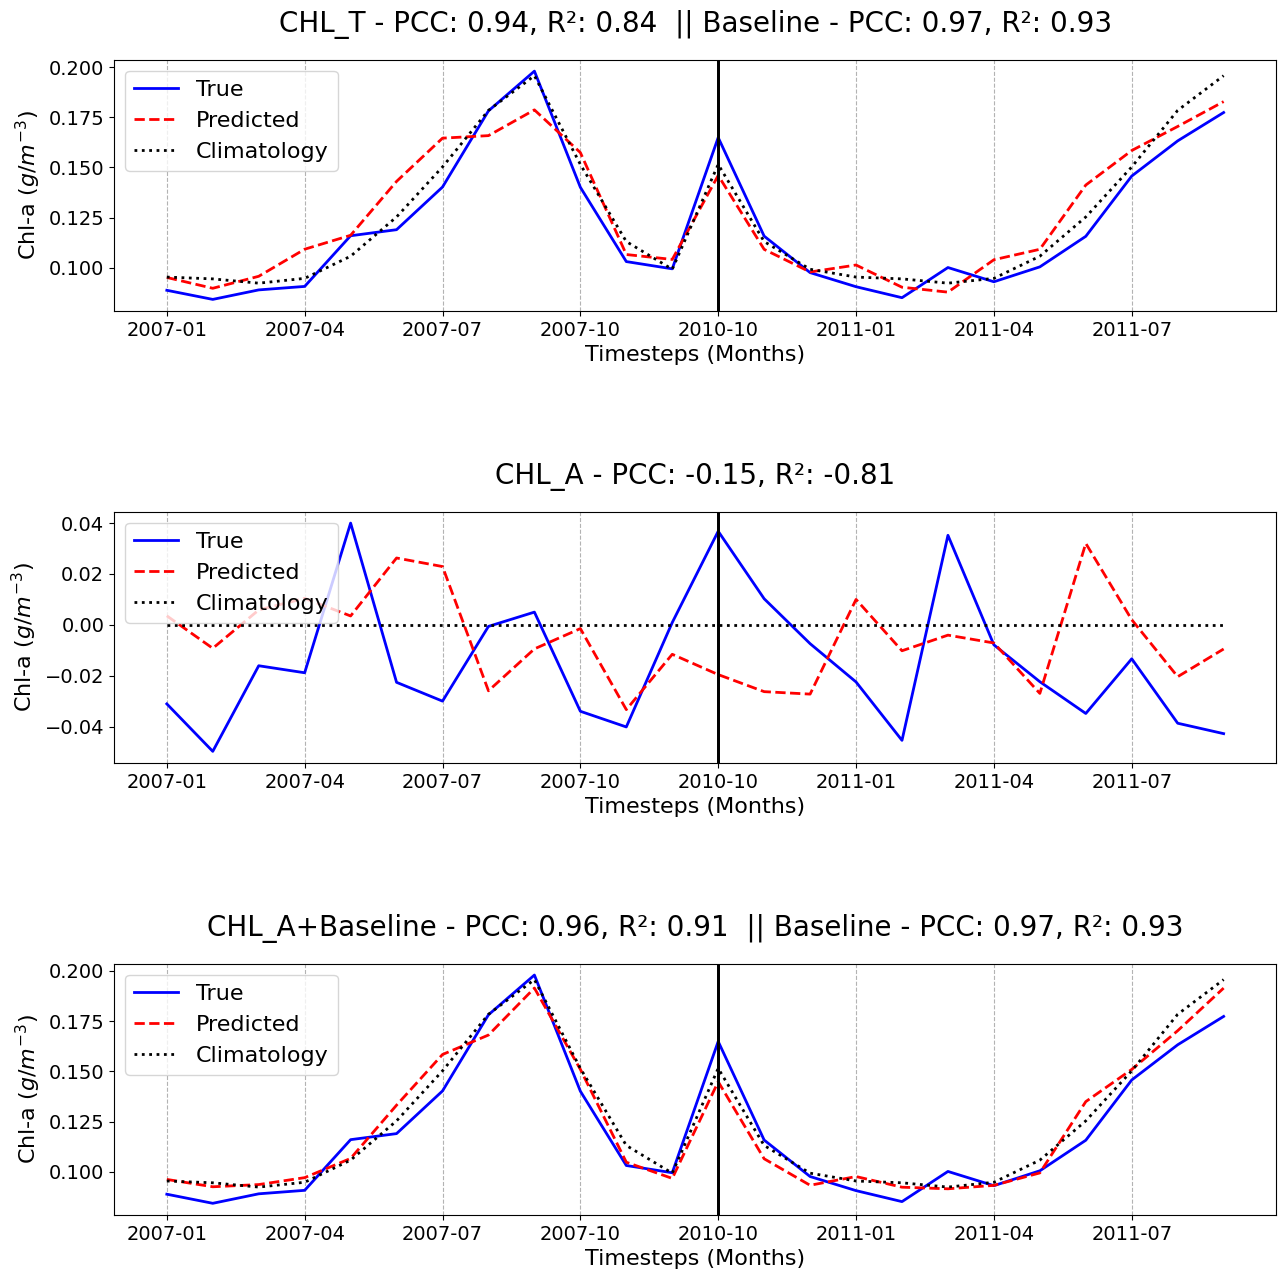

In [102]:
def plot_predictions(avg_pred, y_true, y_clim, y_test_time, test_no, sample=0):
    from sklearn.metrics import r2_score
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    import numpy as np

    def plotting_variables(i, split_index):
        ax[i].set_xlabel('Timesteps (Months)', fontsize=16)
        ax[i].set_ylabel('Chl-a ($g/m^{-3}$)', fontsize=16)
        ax[i].legend(fontsize=16, loc='upper left')
        ax[i].tick_params(axis='both', which='major', labelsize=14)
        ax[i].set_xticks(custom_x_ticks)  # Use custom ticks
        ax[i].set_xticklabels(custom_x_labels)  # Set custom labels
        ax[i].grid(True, which='both', axis='x', linestyle='--', color='0.7')
        
        ax[i].axvline(x=split_index, color='black', linestyle='-', linewidth=2)
            
    y_clim = y_clim.flatten()
    time_range = y_test_time.flatten()
    split_index = np.where(time_range.astype('datetime64[Y]') == np.datetime64('2010'))[0][0]
    # Create custom indices for the x-axis to represent continuous time
    custom_x = np.arange(len(time_range))
    
    # Create labels for the x-axis
    custom_x_ticks = [0, 3, 6, 9, 12, 15, 18, 21]  # Start, end of 2007 period, start of 2010 period, end
    custom_x_labels = [
        time_range[0].astype('datetime64[M]').astype(str), 
        time_range[3].astype('datetime64[M]').astype(str),   
        time_range[6].astype('datetime64[M]').astype(str),   
        time_range[9].astype('datetime64[M]').astype(str),
        time_range[12].astype('datetime64[M]').astype(str),  
        time_range[15].astype('datetime64[M]').astype(str),
        time_range[18].astype('datetime64[M]').astype(str),
        time_range[21].astype('datetime64[M]').astype(str)
    ]

    fig, ax = plt.subplots(3, 1, figsize=(15, 15))

    ### Plot chl ###
    true_values = y_true[sample, :, :, 1].flatten()
    predicted_values = avg_pred[sample, :, :, 1].flatten()

    r_squared = r2_score(true_values, predicted_values)
    corr_coef, _ = stats.pearsonr(true_values, predicted_values)
    r_squared_baseline = r2_score(true_values, y_clim)
    corr_coef_baseline, _ = stats.pearsonr(true_values, y_clim)

    ax[0].plot(custom_x, np.power(10, true_values), label='True', color='blue', linewidth=2)
    ax[0].plot(custom_x, np.power(10, predicted_values), label='Predicted', color='red', linestyle='dashed', linewidth=2)
    ax[0].plot(custom_x, np.power(10, y_clim), label='Climatology', color='black', linestyle='dotted', linewidth=2)
    ax[0].axvline(x=12, color='black', linestyle='-', linewidth=2)  # Add a vertical line to differentiate the periods
    ax[0].set_title(f'CHL_T - PCC: {corr_coef:.2f}, R²: {r_squared:.2f}  || Baseline - PCC: {corr_coef_baseline:.2f}, R²: {r_squared_baseline:.2f}', fontsize=20, pad=20)
    plotting_variables(0, split_index)
    
    ### Plot chl anomaly ###
    true_values_A = y_true[sample, :, :, 0].flatten()
    predicted_values_A = avg_pred[sample, :, :, 0].flatten()
    zero_clim = np.zeros((true_values.shape[0],))

    r_squared = r2_score(true_values_A, predicted_values_A)
    corr_coef, _ = stats.pearsonr(true_values_A, predicted_values_A)
    r_squared_baseline = r2_score(true_values_A, zero_clim)
    corr_coef_baseline, _ = stats.pearsonr(true_values_A, zero_clim)

    ax[1].plot(custom_x, true_values_A, label='True', color='blue', linewidth=2)
    ax[1].plot(custom_x, predicted_values_A, label='Predicted', color='red', linestyle='dashed', linewidth=2)
    ax[1].plot(custom_x, zero_clim, label='Climatology', color='black', linestyle='dotted', linewidth=2)
    ax[1].axvline(x=12, color='black', linestyle='-', linewidth=2)  # Add a vertical line
    ax[1].set_title(f'CHL_A - PCC: {corr_coef:.2f}, R²: {r_squared:.2f}', fontsize=20, pad=20)
    plotting_variables(1, split_index)

    ### Plot chl anomaly + baseline ###
    true_values_AB = y_true[sample, :, :, 0].flatten() + y_clim
    predicted_values_AB = avg_pred[sample, :, :, 0].flatten() + y_clim

    r_squared = r2_score(true_values_AB, predicted_values_AB)
    corr_coef, _ = stats.pearsonr(true_values_AB, predicted_values_AB)
    r_squared_baseline = r2_score(true_values_AB, y_clim)
    corr_coef_baseline, _ = stats.pearsonr(true_values_AB, y_clim)

    ax[2].plot(custom_x, np.power(10, true_values_AB), label='True', color='blue', linewidth=2)
    ax[2].plot(custom_x, np.power(10, predicted_values_AB), label='Predicted', color='red', linestyle='dashed', linewidth=2)
    ax[2].plot(custom_x, np.power(10, y_clim), label='Climatology', color='black', linestyle='dotted', linewidth=2)
    ax[2].axvline(x=12, color='black', linestyle='-', linewidth=2)  # Add a vertical line
    ax[2].set_title(f'CHL_A+Baseline - PCC: {corr_coef:.2f}, R²: {r_squared:.2f}  || Baseline - PCC: {corr_coef_baseline:.2f}, R²: {r_squared_baseline:.2f}', fontsize=20, pad=20)
    plotting_variables(2, split_index)

    # Adjust space between subplots
    plt.subplots_adjust(hspace=0.8)
    
    # Optionally save the figure
    # plt.savefig(f'/work3/anscha/Marine_heat_waves/Manuscript2_figures/Area: {test_no}_TNN_batch_15', dpi = 300, bbox_inches='tight')
    
    plt.show()

y_clim = np.mean(y_test_clim, axis=0, keepdims=True)
plot_predictions(area_test_predicted_output_orig, area_y_test_orig, y_clim, y_test_time, test_no, sample=0)

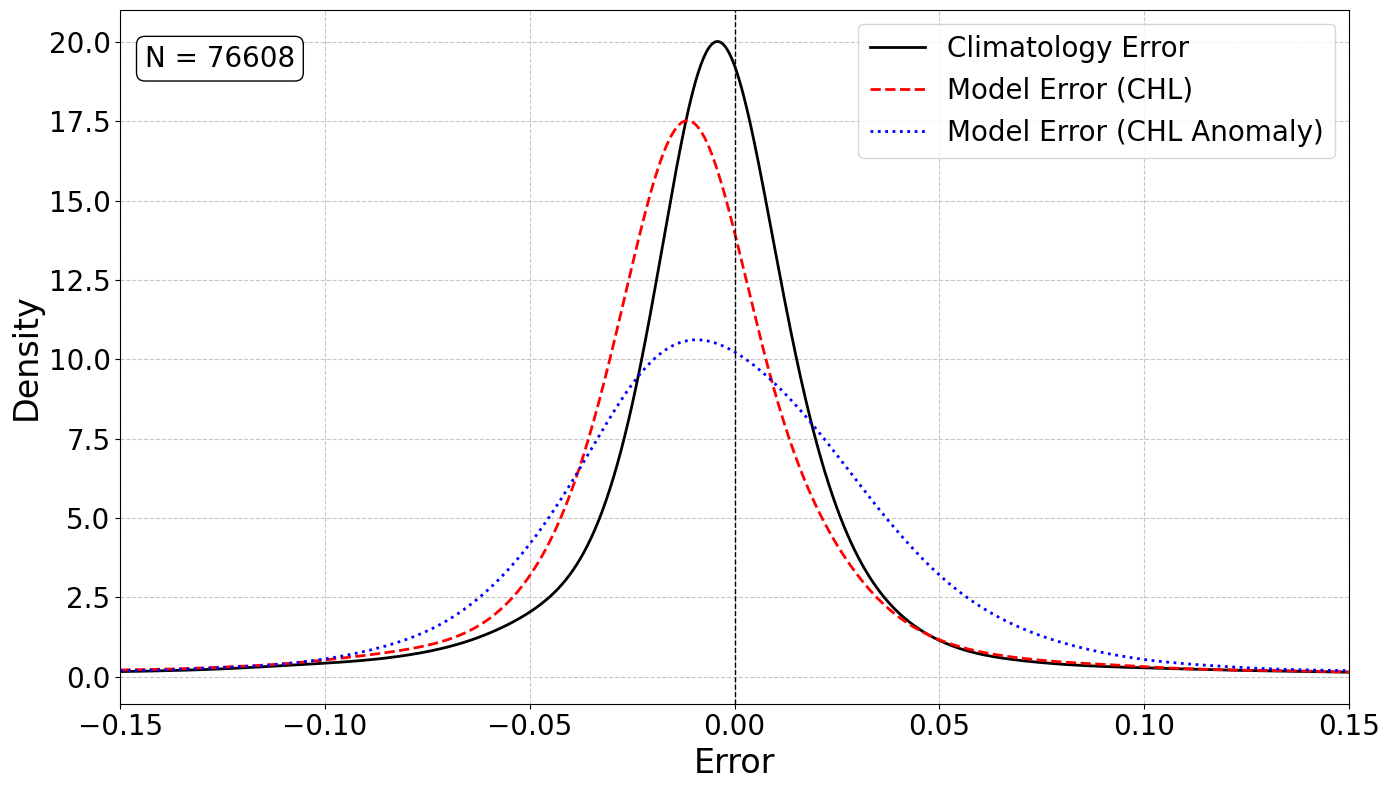

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

predicted_chl = np.power(10, test_predicted_output_orig[..., 1].reshape(-1, 1))
true_chl = np.power(10, y_test_orig[..., 1].reshape(-1, 1))
true_chl_clim = np.power(10, y_test_clim.reshape(-1, 1))
predicted_chl_anomaly = test_predicted_output_orig[..., 0].reshape(-1, 1)

error_by_model = true_chl - predicted_chl
error_by_model_for_anomaly_pred = true_chl - (predicted_chl_anomaly + true_chl_clim)
error_by_baseline = true_chl - true_chl_clim

# Number of samples
num_samples = error_by_baseline.size

x_lim = 0.15 ## 0.15 or 1
# Define a range for the x-axis
x_range = np.linspace(-x_lim, x_lim, 1000)

# Calculate KDE for each error
kde_baseline = gaussian_kde(error_by_baseline.flatten())
kde_model = gaussian_kde(error_by_model.flatten())
kde_anomaly = gaussian_kde(error_by_model_for_anomaly_pred.flatten())

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting KDE smoothed curves
ax.plot(x_range, kde_baseline(x_range), color='black', linestyle='-', label='Climatology Error', linewidth=2)
ax.plot(x_range, kde_model(x_range), color='red', linestyle='--', label='Model Error (CHL)', linewidth=2)
ax.plot(x_range, kde_anomaly(x_range), color='blue', linestyle=':', label='Model Error (CHL Anomaly)', linewidth=2)

ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Adding titles and labels
ax.set_xlabel('Error', fontsize=24)
ax.set_ylabel('Density', fontsize=24)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', fontsize=20)
ax.set_xlim(-x_lim, x_lim)
ax.tick_params(axis='both', which='major', labelsize=20)

# Adding number of samples annotation
ax.text(0.02, 0.95, f'N = {num_samples}', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=dict(boxstyle="round, pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()

# SHAP Analysis

In [187]:
samples_train = 100; n_selected_samples_train = samples_train*data_shape['n_seq_train']

selected_samples = np.random.choice(np.arange(X_train.shape[0]), size=n_selected_samples_train, replace=False)
X_train_shap = torch.tensor(X_train, dtype=torch.float)[selected_samples].to(device)

### select pixel for which we want to see the contribution
samples_test = data_shape['n_samples']; n_selected_samples_test = samples_test*data_shape['n_seq_test'] 
X_test_selected = X_test[:n_selected_samples_test] ## selecting data for selected pixels
X_test_shap = X_test_selected.reshape(samples_test, data_shape['n_seq_test'], X_test_selected.shape[1], X_test_selected.shape[2])
X_test_shap = np.nanmean(X_test_shap, axis = 0)
X_test_shap = torch.tensor(X_test_shap, dtype=torch.float).to(device)

In [188]:
## for input timesteps = (0,1,2,3)
explainer = shap.GradientExplainer(model, X_train_shap[:,:input_timesteps,:])
shap_values1 = explainer.shap_values(X_test_shap[:,:input_timesteps,:])

## for input timesteps = (1,2,3,4)
explainer = shap.GradientExplainer(model, X_train_shap[:,1:input_timesteps+1,:])
shap_values2 = explainer.shap_values(X_test_shap[:,1:input_timesteps+1,:])

## for input timesteps = (2,3,4,5)
explainer = shap.GradientExplainer(model, X_train_shap[:,2:input_timesteps+2,:])
shap_values3 = explainer.shap_values(X_test_shap[:,2:input_timesteps+2,:])

shap_values = np.stack((shap_values1, shap_values2, shap_values3), axis = 0)

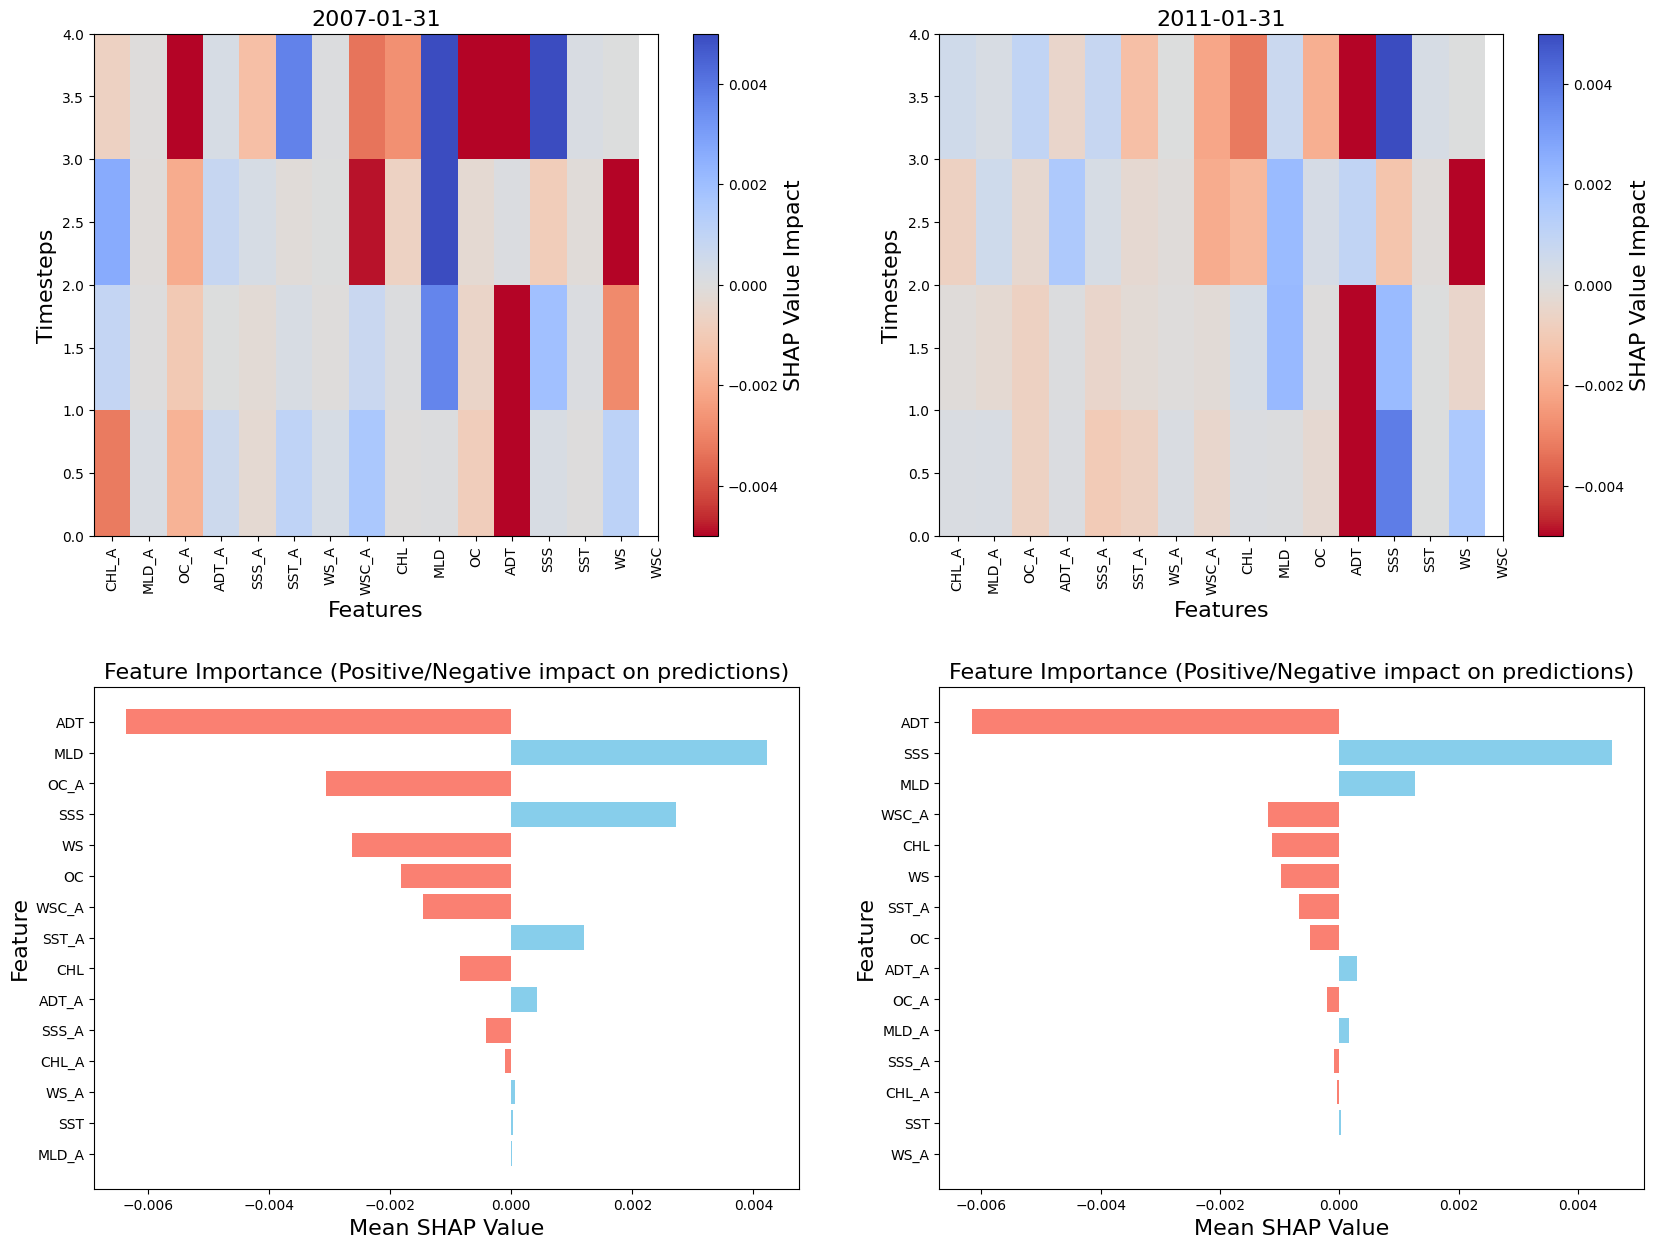

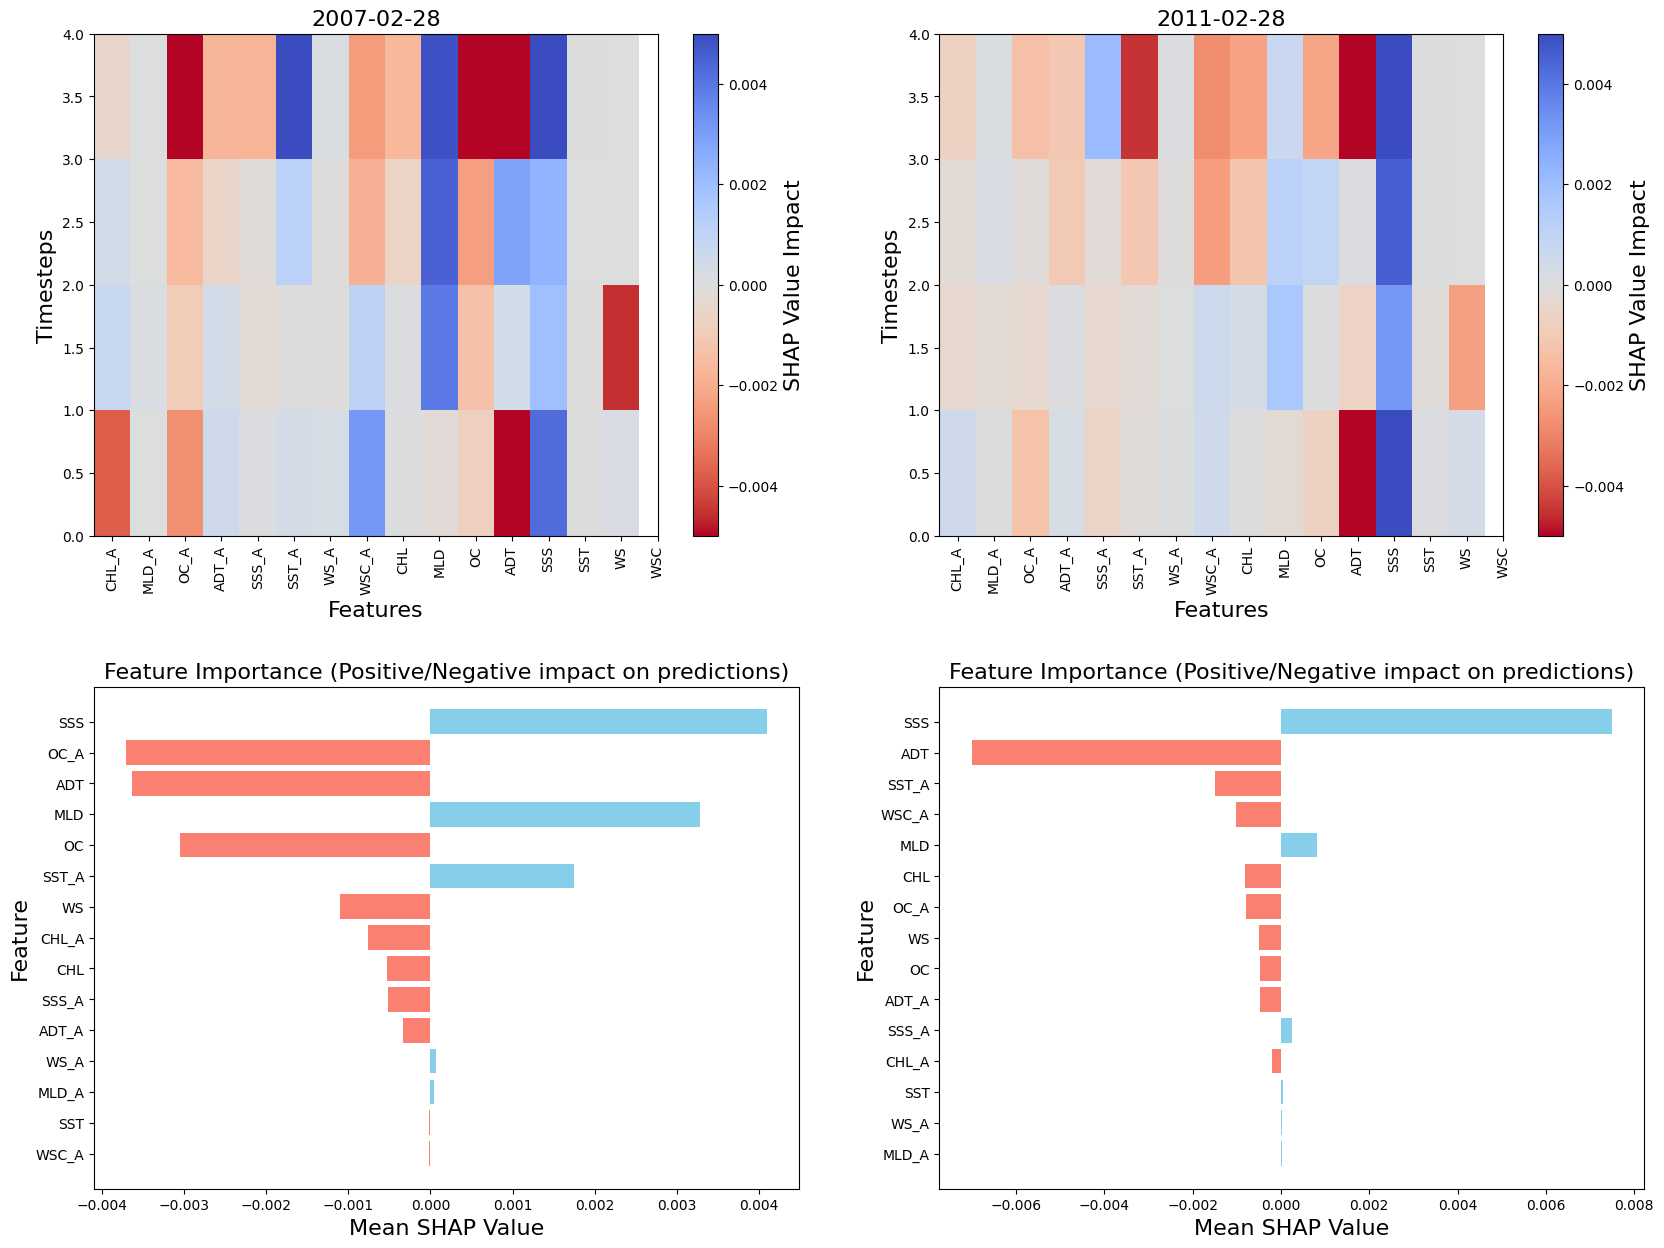

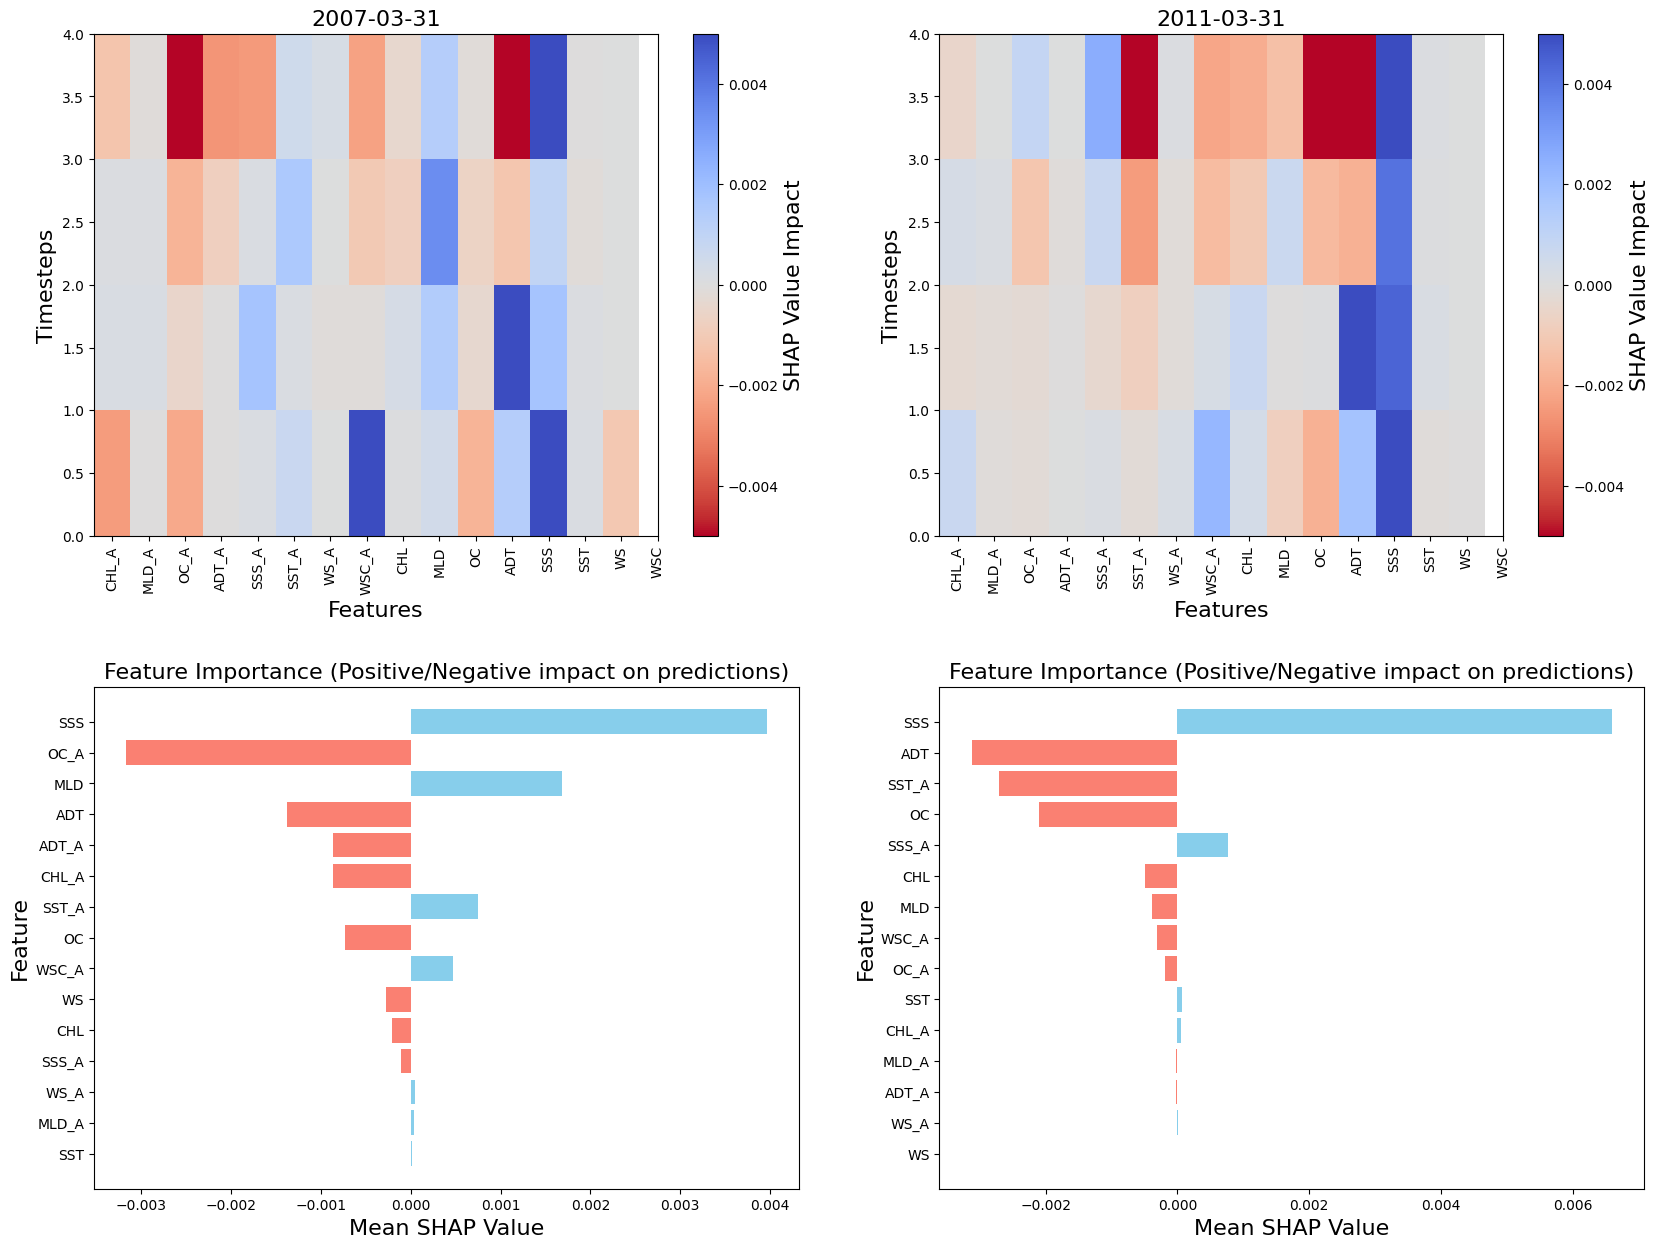

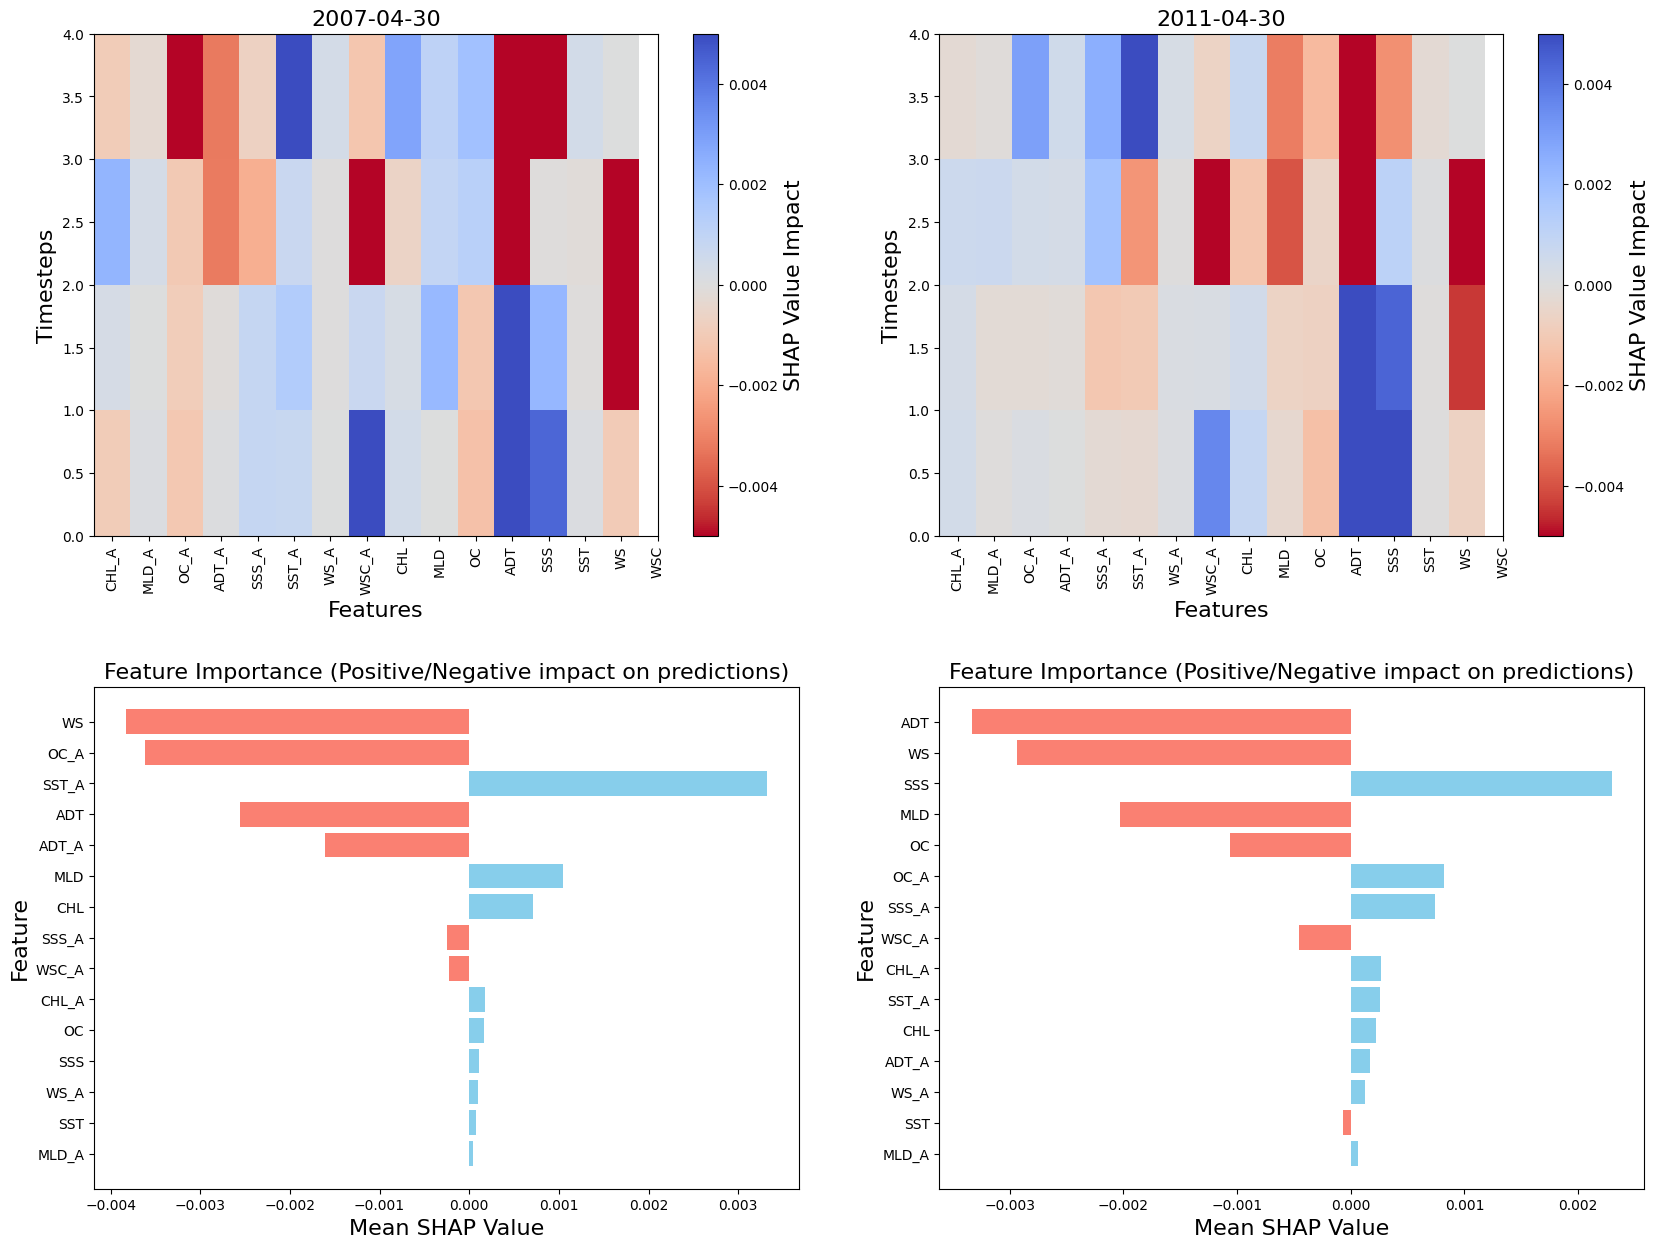

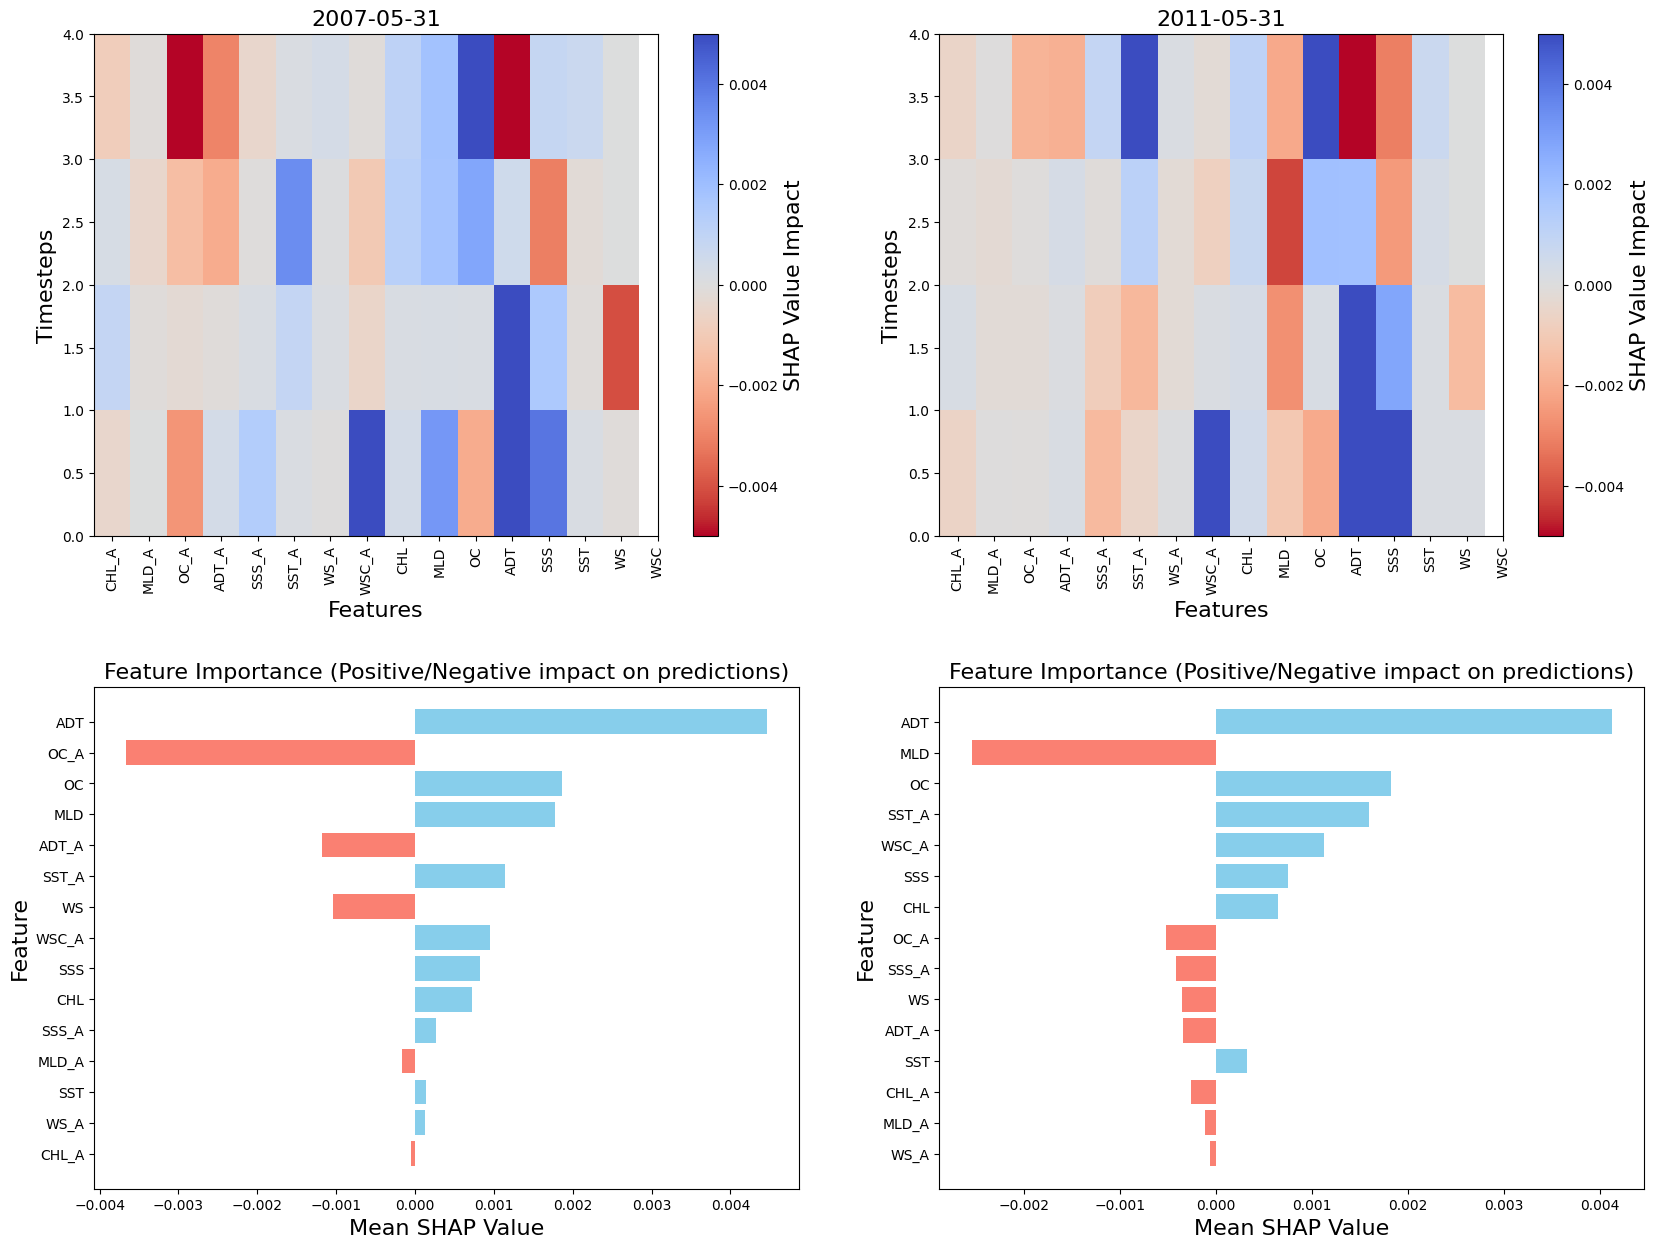

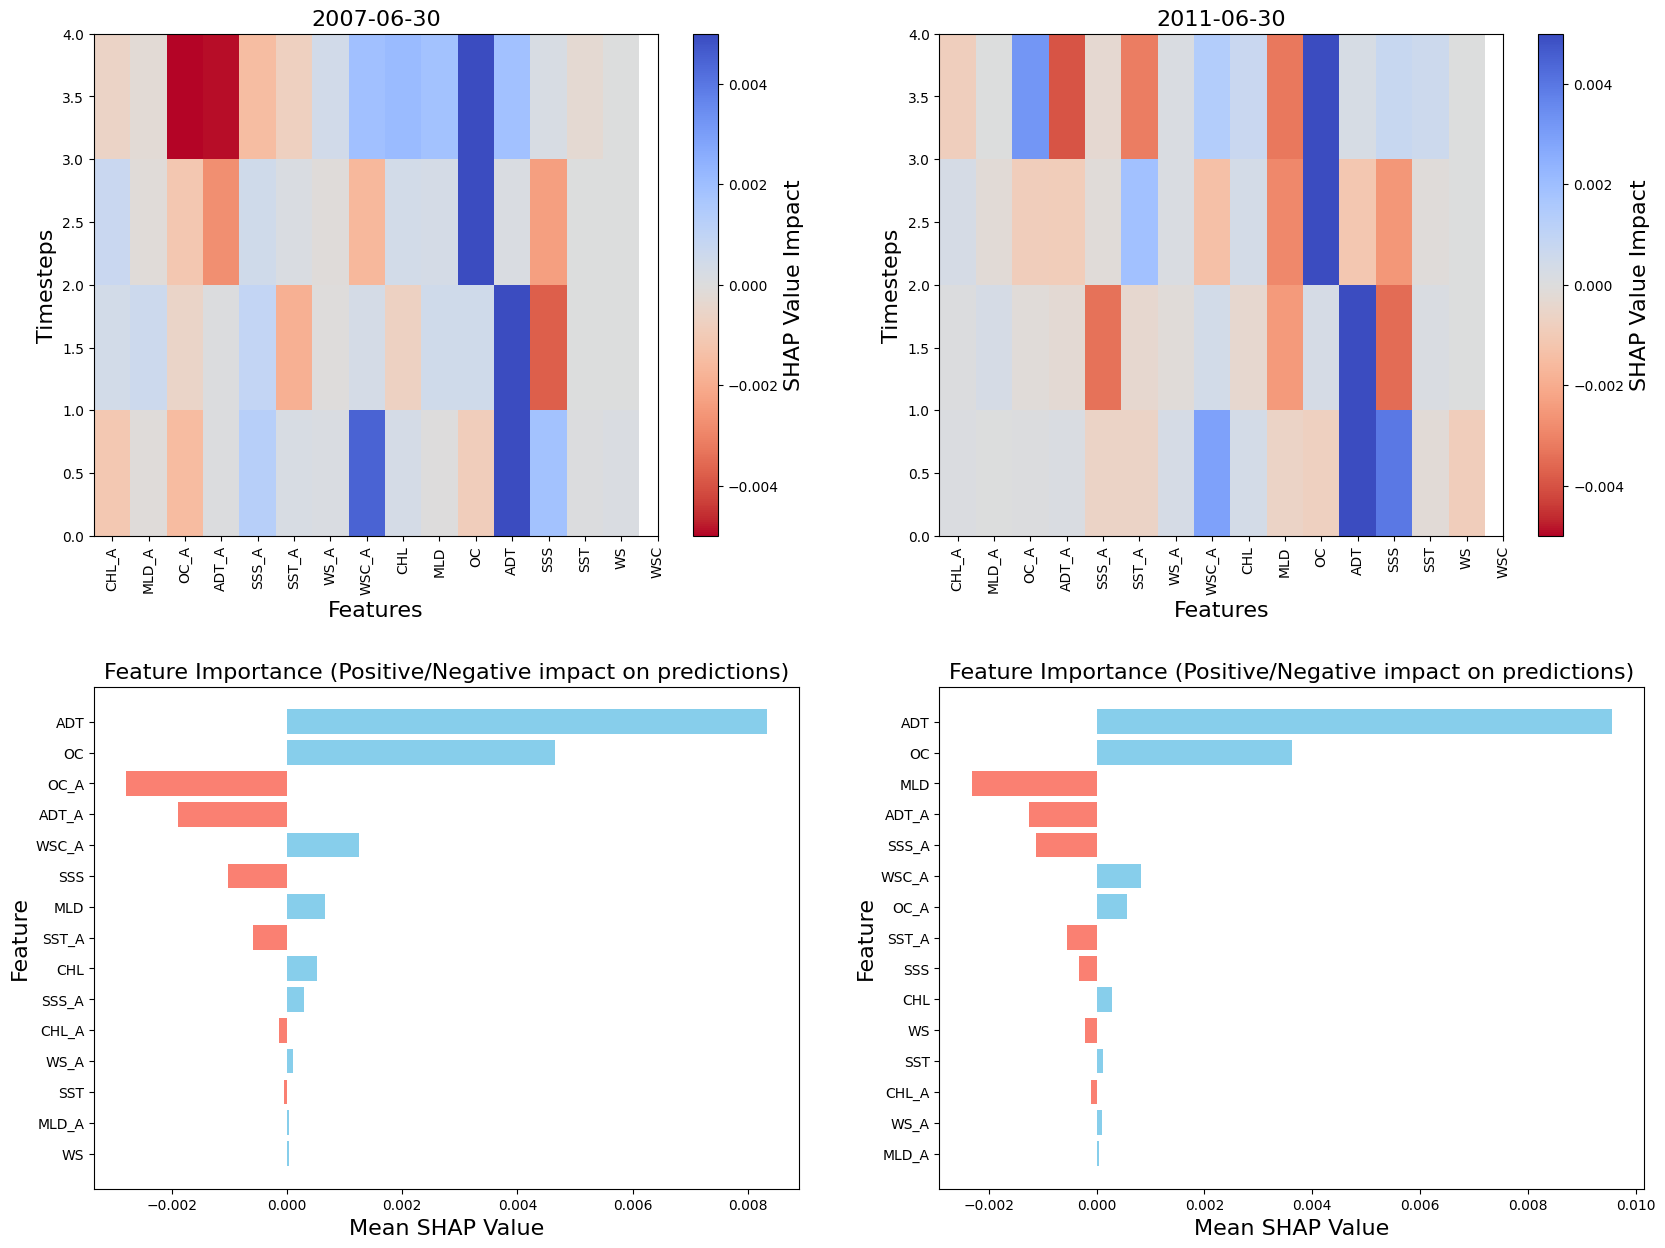

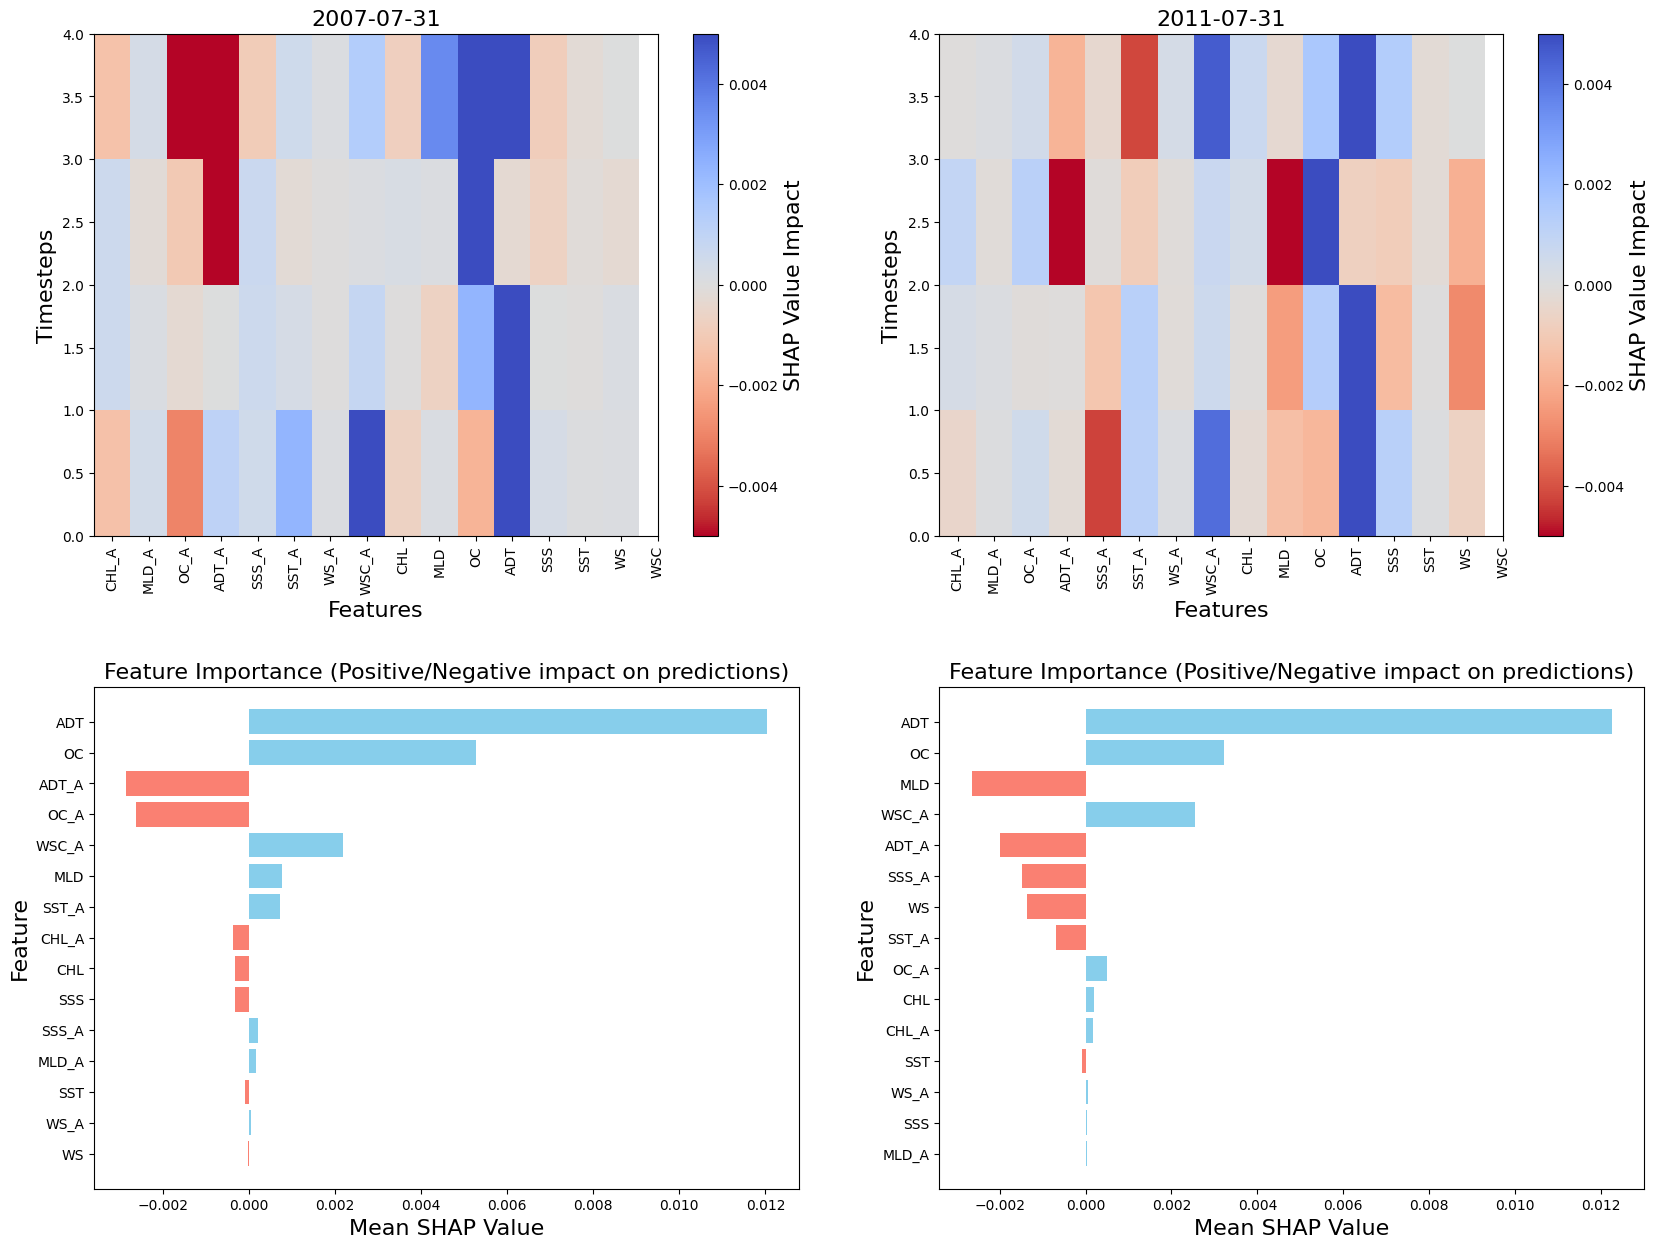

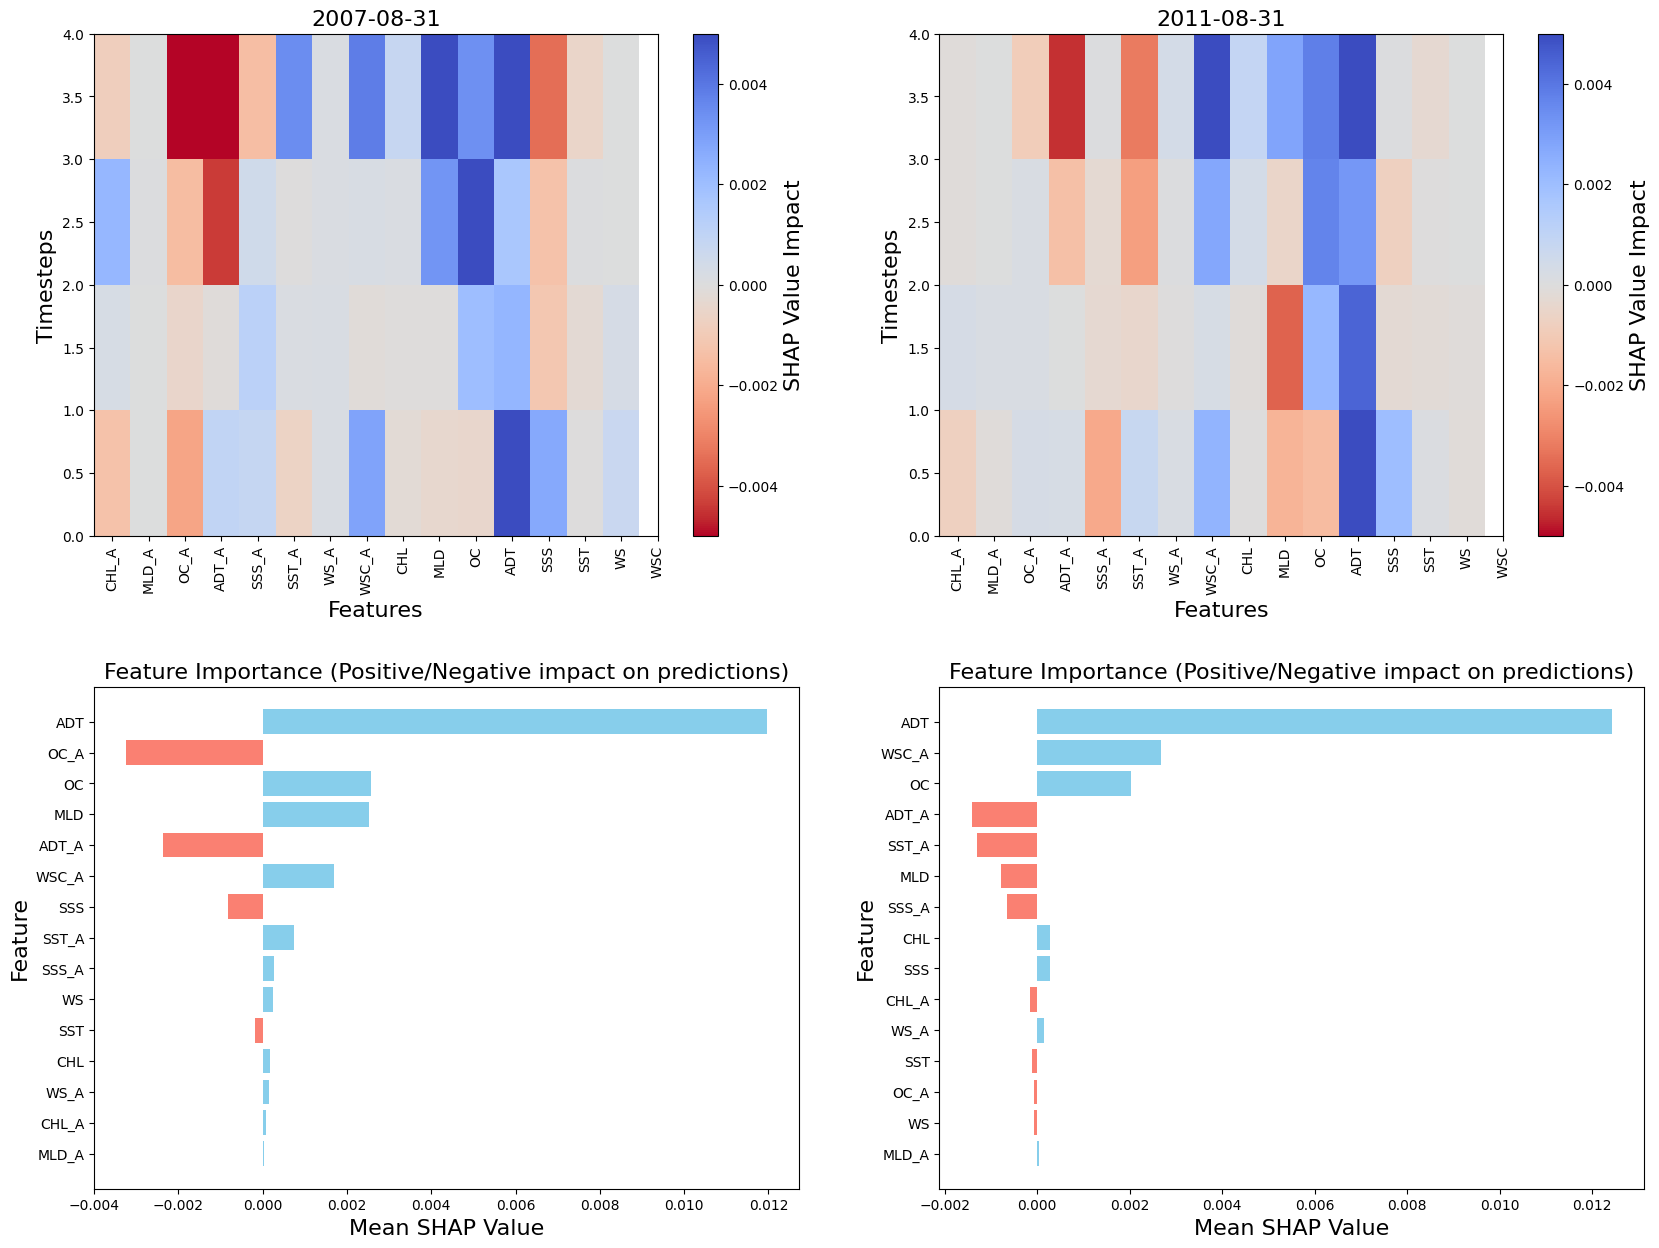

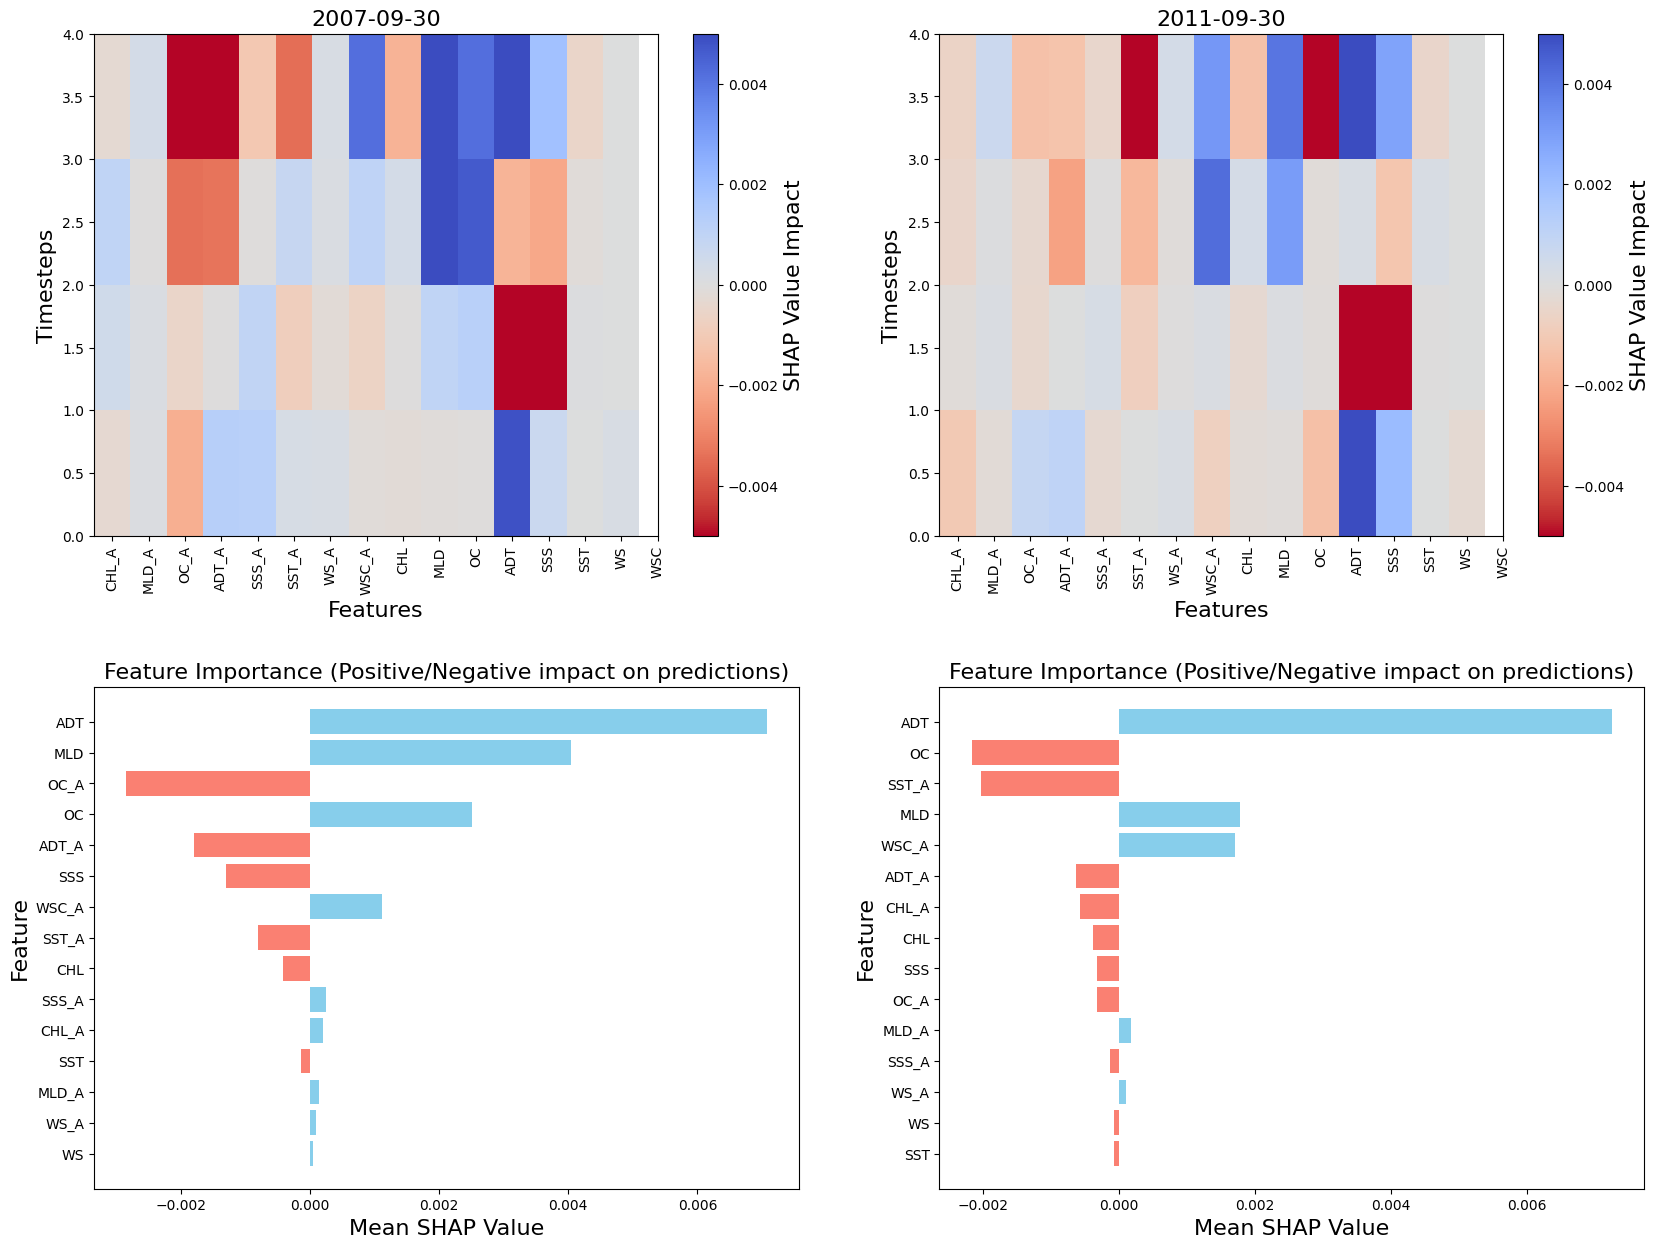

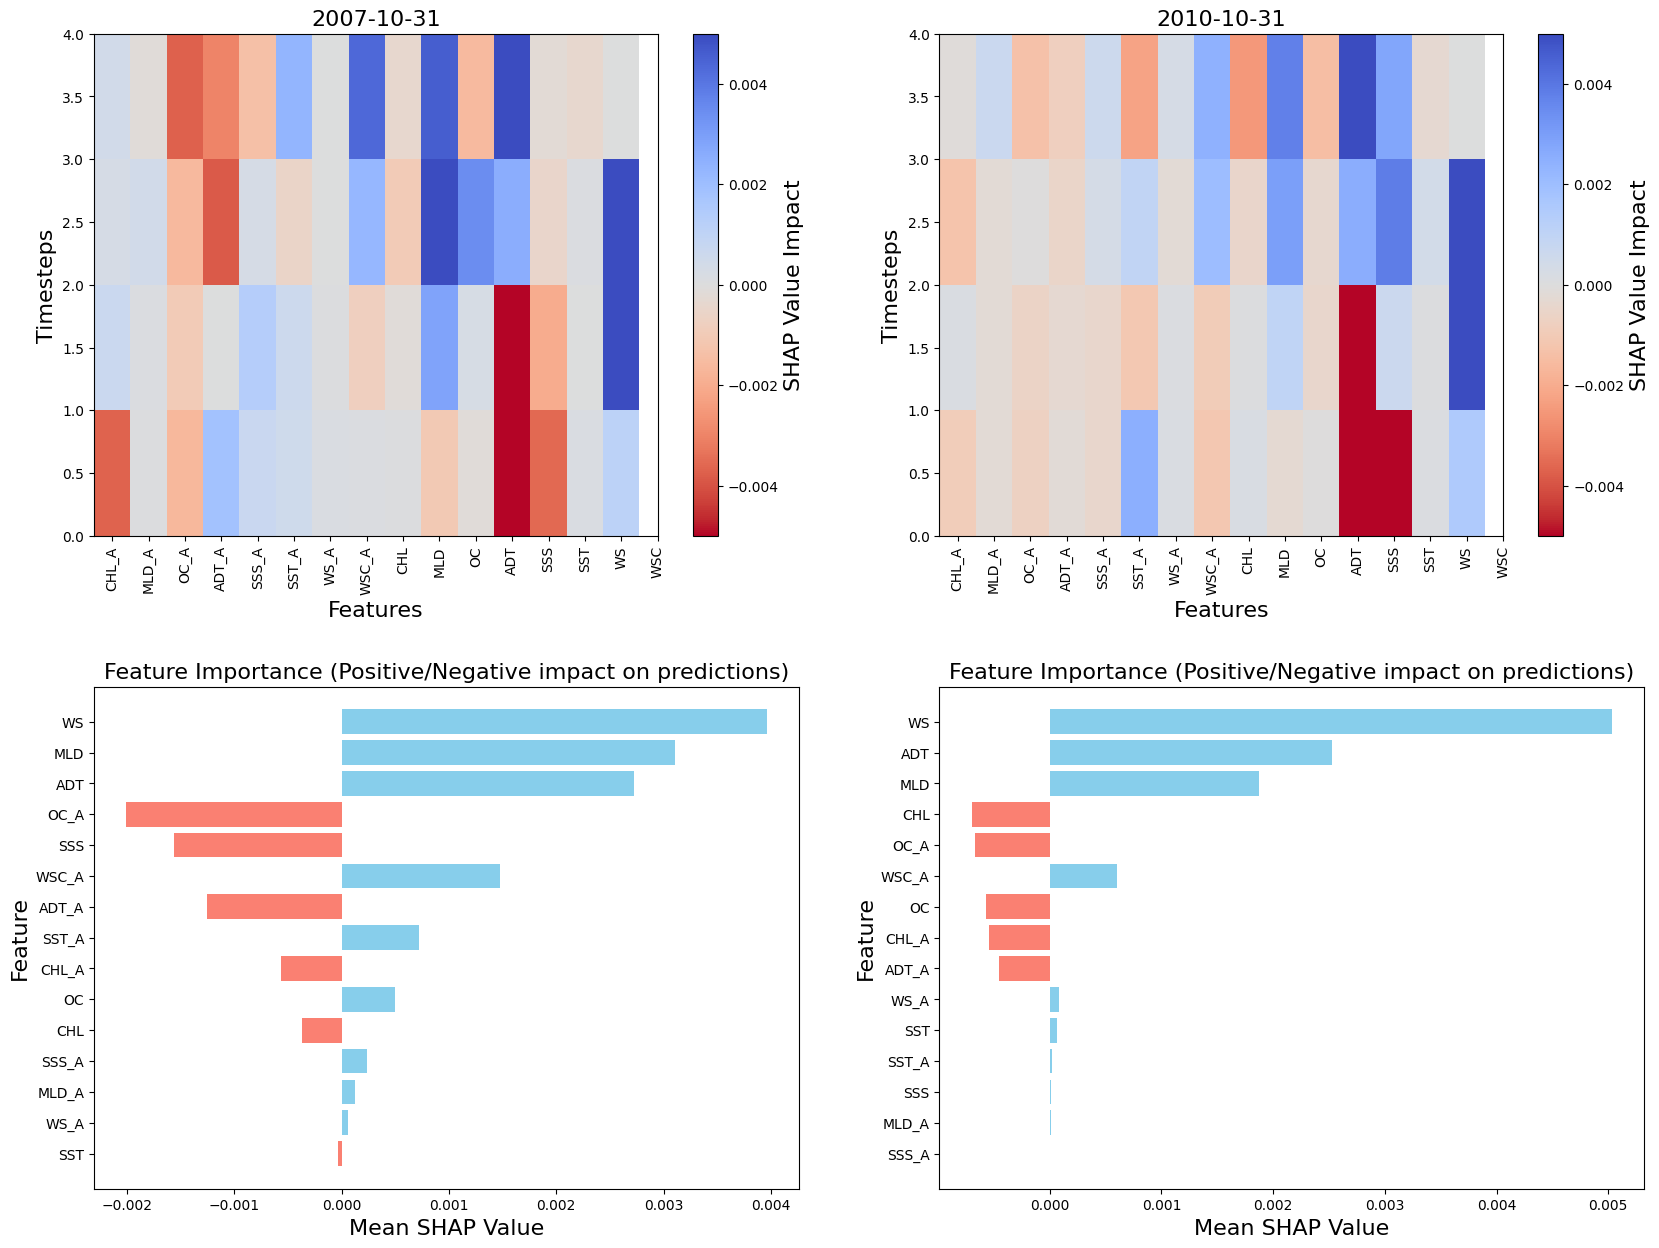

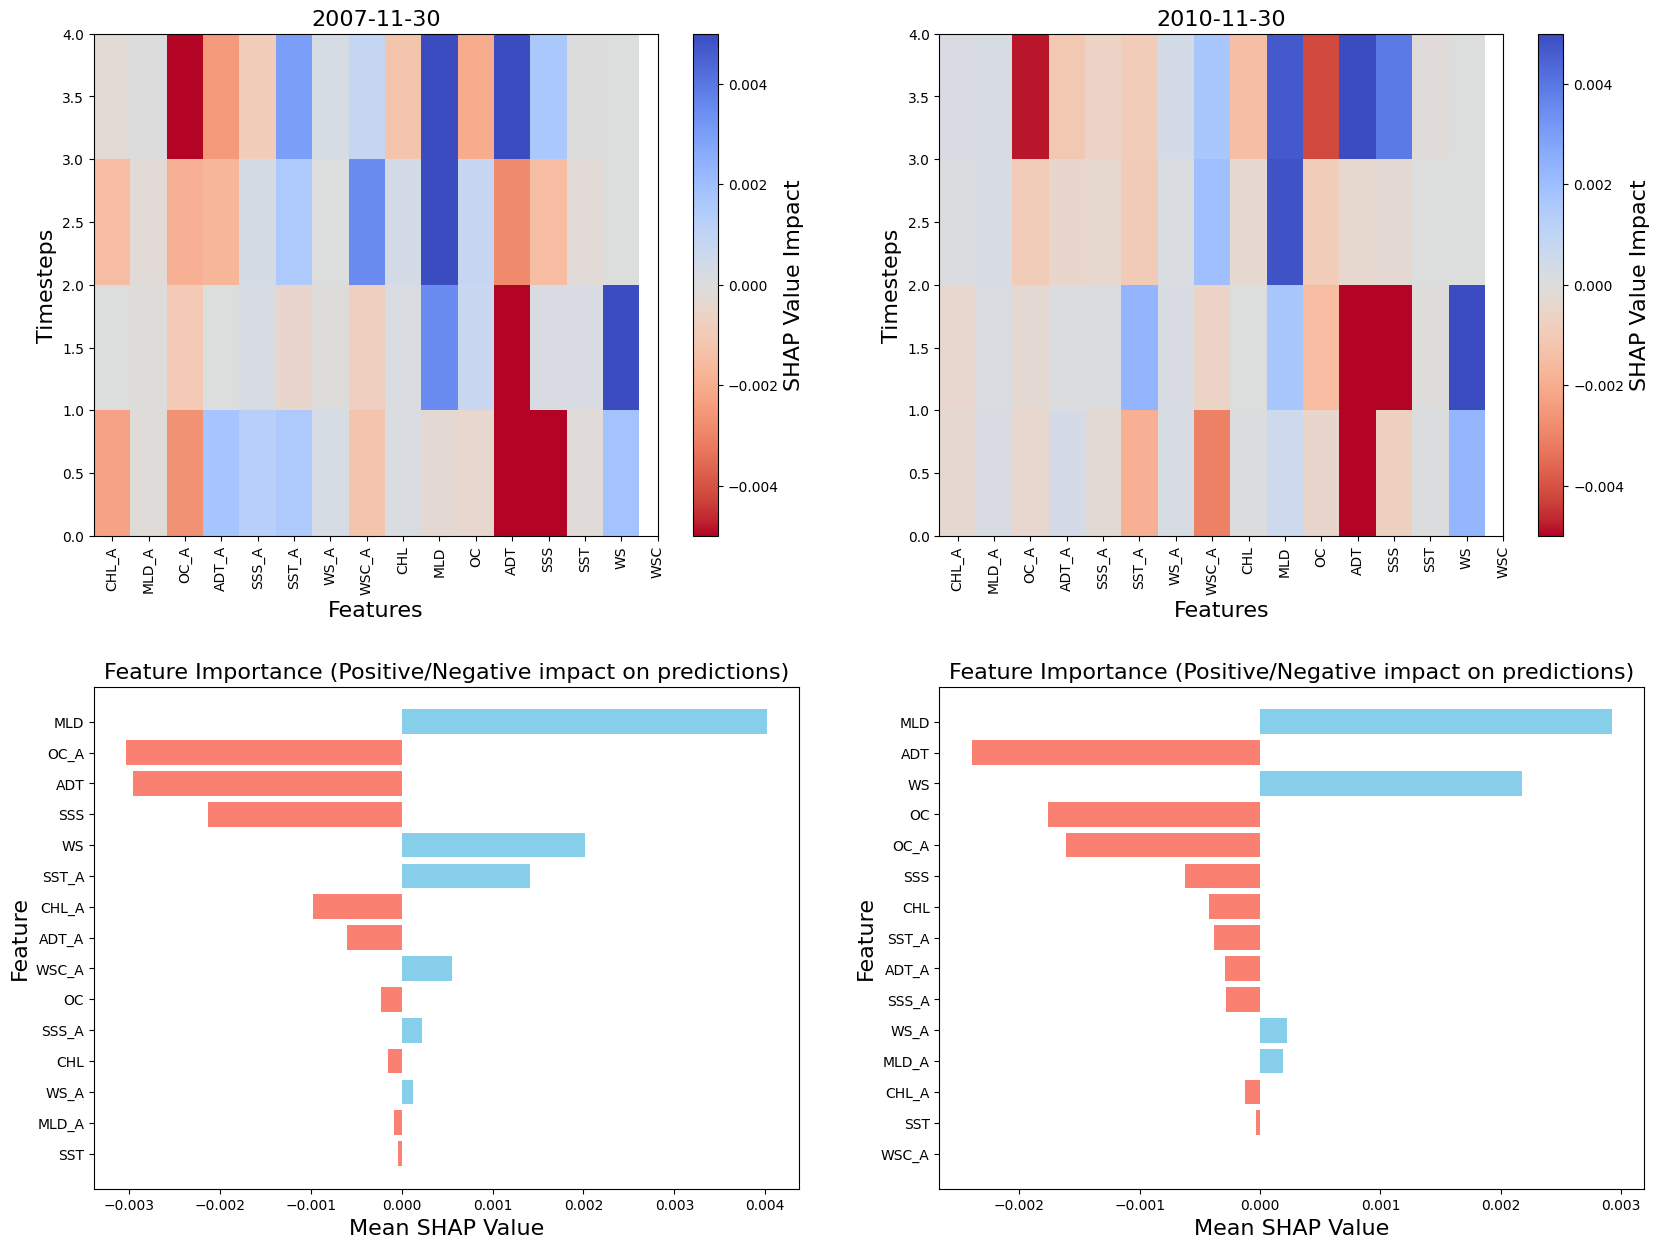

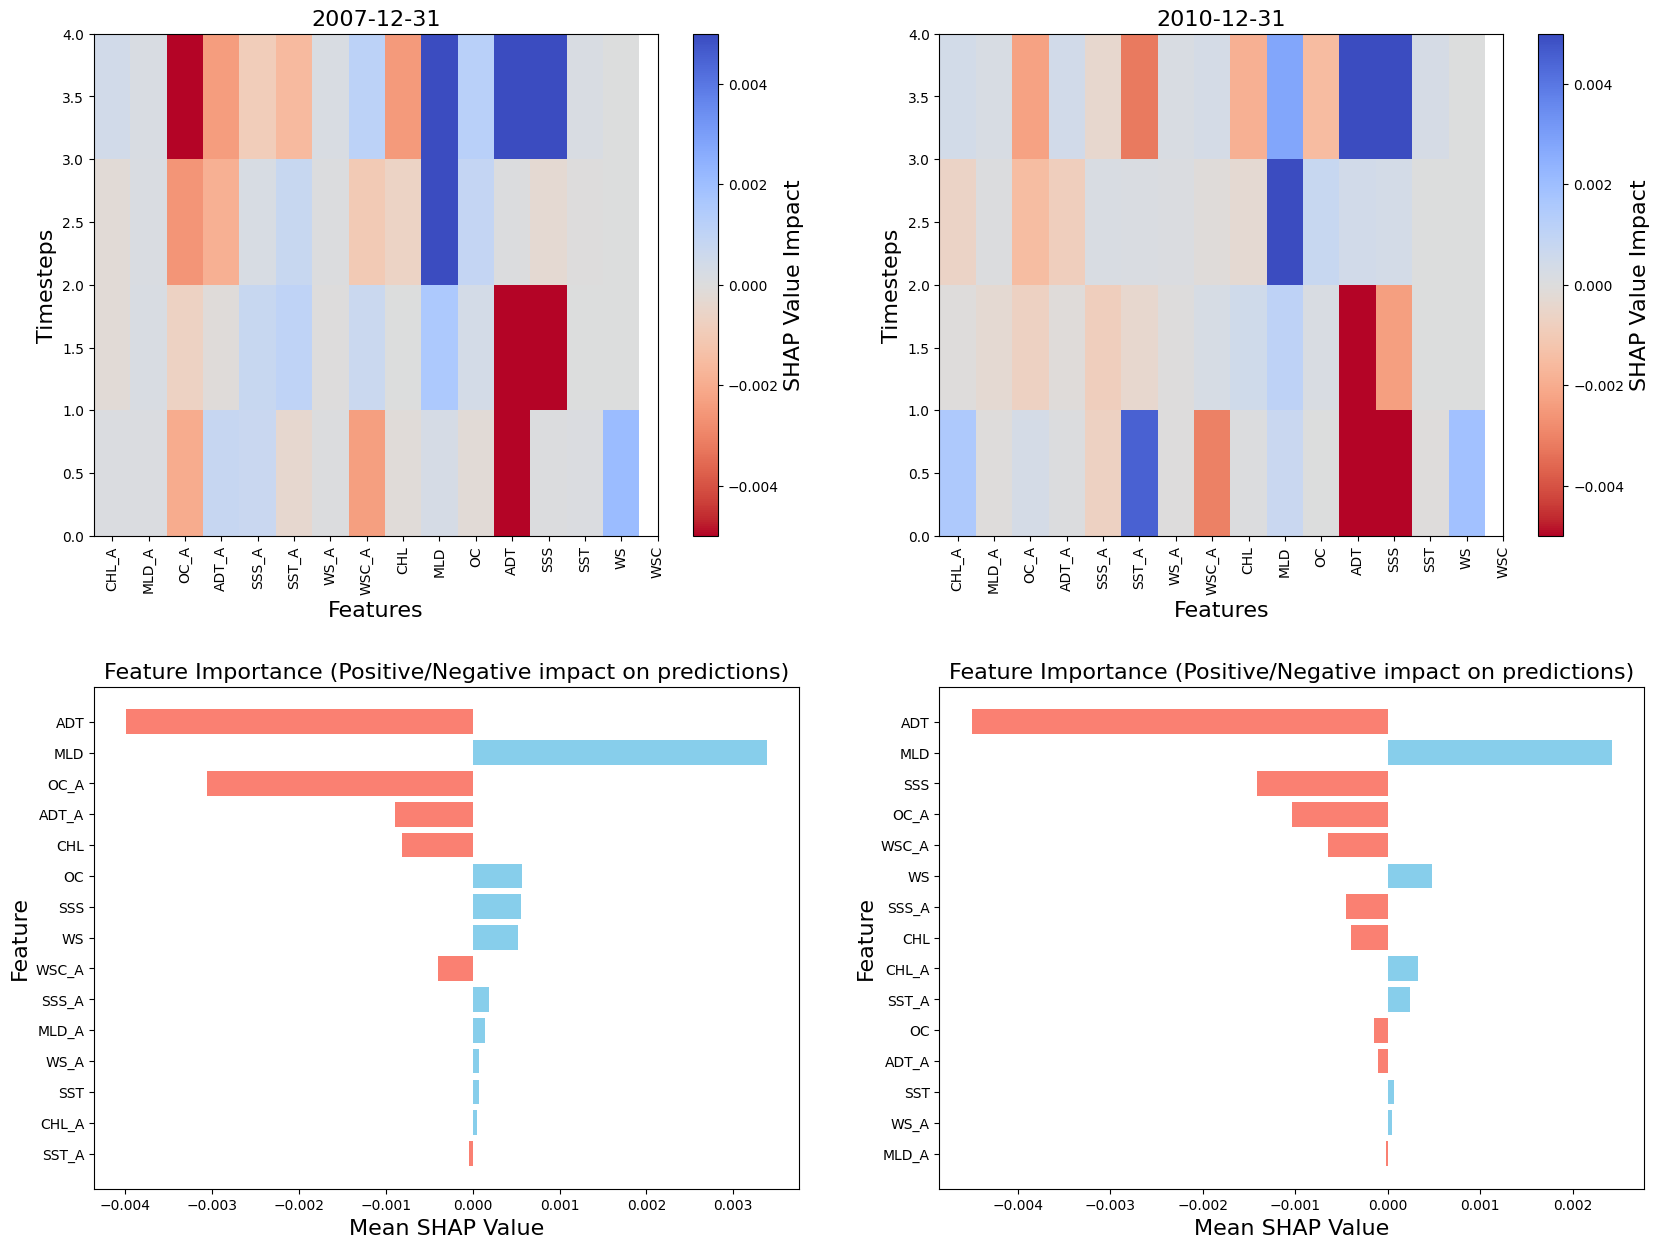

In [189]:
vars = np.array(['CHL', 'MLD', 'OC', 'ADT', 'SSS', 'SST', 'WS', 'WSC'])
variables_A = np.array([f'{var}_A' for var in vars])
var_list = np.append(variables_A, vars)
months = np.arange(1, 13)

common_variables = []
common_variables_shap_values = []
all_sets_features = []
all_sets_shap_values = []

for month in months:
    flat_timestamps = y_test_time.flatten()
    flat_months = flat_timestamps.astype('datetime64[M]').astype(int) % 12 + 1
    month_indices = flat_months.reshape(y_test_time.squeeze().shape)
    batch_timestep = np.argwhere(month_indices == month)
    
    # Extract the month component from each timestamp
    fig, ax = plt.subplots(2, batch_timestep.shape[0], figsize=(10*batch_timestep.shape[0], 15))
    top_five_features = []
    top_five_shap_values = []
    for i in range(batch_timestep.shape[0]):
        batch = batch_timestep[i, 0]
        chl_timestep = batch_timestep[i, 1]
    
        # Calculate the mean SHAP value (considering both positive and negative) for each feature
        mean_shap_values = np.mean(shap_values[chl_timestep][batch,:len(vars)], axis=0)
        
        # Sort the features and SHAP values by the absolute mean importance
        sorted_indices = np.argsort(np.abs(mean_shap_values))[::-1]  # Sort by absolute mean SHAP value in descending order
        sorted_features = var_list[sorted_indices]
        sorted_mean_shap_values = mean_shap_values[sorted_indices]
        top_five_features.append(sorted_features[:8]) ## top five features
        top_five_shap_values.append(sorted_mean_shap_values[:8]) ## top five features
        month_name = y_test_time.squeeze()[tuple(batch_timestep[i])]
        
        ##############################################################################
        ##### plot the variable contribution for each variable with timestep #########
        ##############################################################################
        mesh = ax[0, i].pcolormesh(shap_values[chl_timestep][batch,:len(vars)], cmap='coolwarm_r', vmin = -0.005, vmax = 0.005)
        cbar = fig.colorbar(mesh, ax=ax[0, i])
        cbar.set_label('SHAP Value Impact', fontsize = 16)
        ax[0, i].set_xticks(ticks=np.arange(len(var_list)) + 0.5, labels=var_list, rotation='vertical')  # Rotate labels if they overlap
        ax[0, i].set_ylabel('Timesteps', fontsize = 16)
        ax[0, i].set_xlabel('Features', fontsize = 16)
        ax[0, i].set_title(f'{month_name}'[:10], fontsize = 16)
        
        ##############################################################################
        ##### plot in general feature importance #########
        ##############################################################################
        bars = ax[1, i].barh(sorted_features, sorted_mean_shap_values, color=np.where(sorted_mean_shap_values >= 0, 'skyblue', 'salmon'))
        ax[1, i].set_xlabel('Mean SHAP Value', fontsize = 16)
        ax[1, i].set_ylabel('Feature', fontsize = 16)
        ax[1, i].set_title('Feature Importance (Positive/Negative impact on predictions)', fontsize = 16)
        ax[1, i].invert_yaxis()  # Invert y-axis to have the most important feature at the top

    sets_features = [set(row) for row in top_five_features]
    
    sets_shap_values = [dict(zip(row, top_five_shap_values[idx])) for idx, row in enumerate(top_five_features)]
    common_vars = set.intersection(*sets_features)

    # Calculate the mean SHAP values for the common variables using sets_shap_values
    common_shap_vals = {var: np.mean([shap_dict[var] for shap_dict in sets_shap_values if var in shap_dict]) for var in common_vars}

    common_variables.append(common_vars)
    common_variables_shap_values.append(common_shap_vals)
    
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()

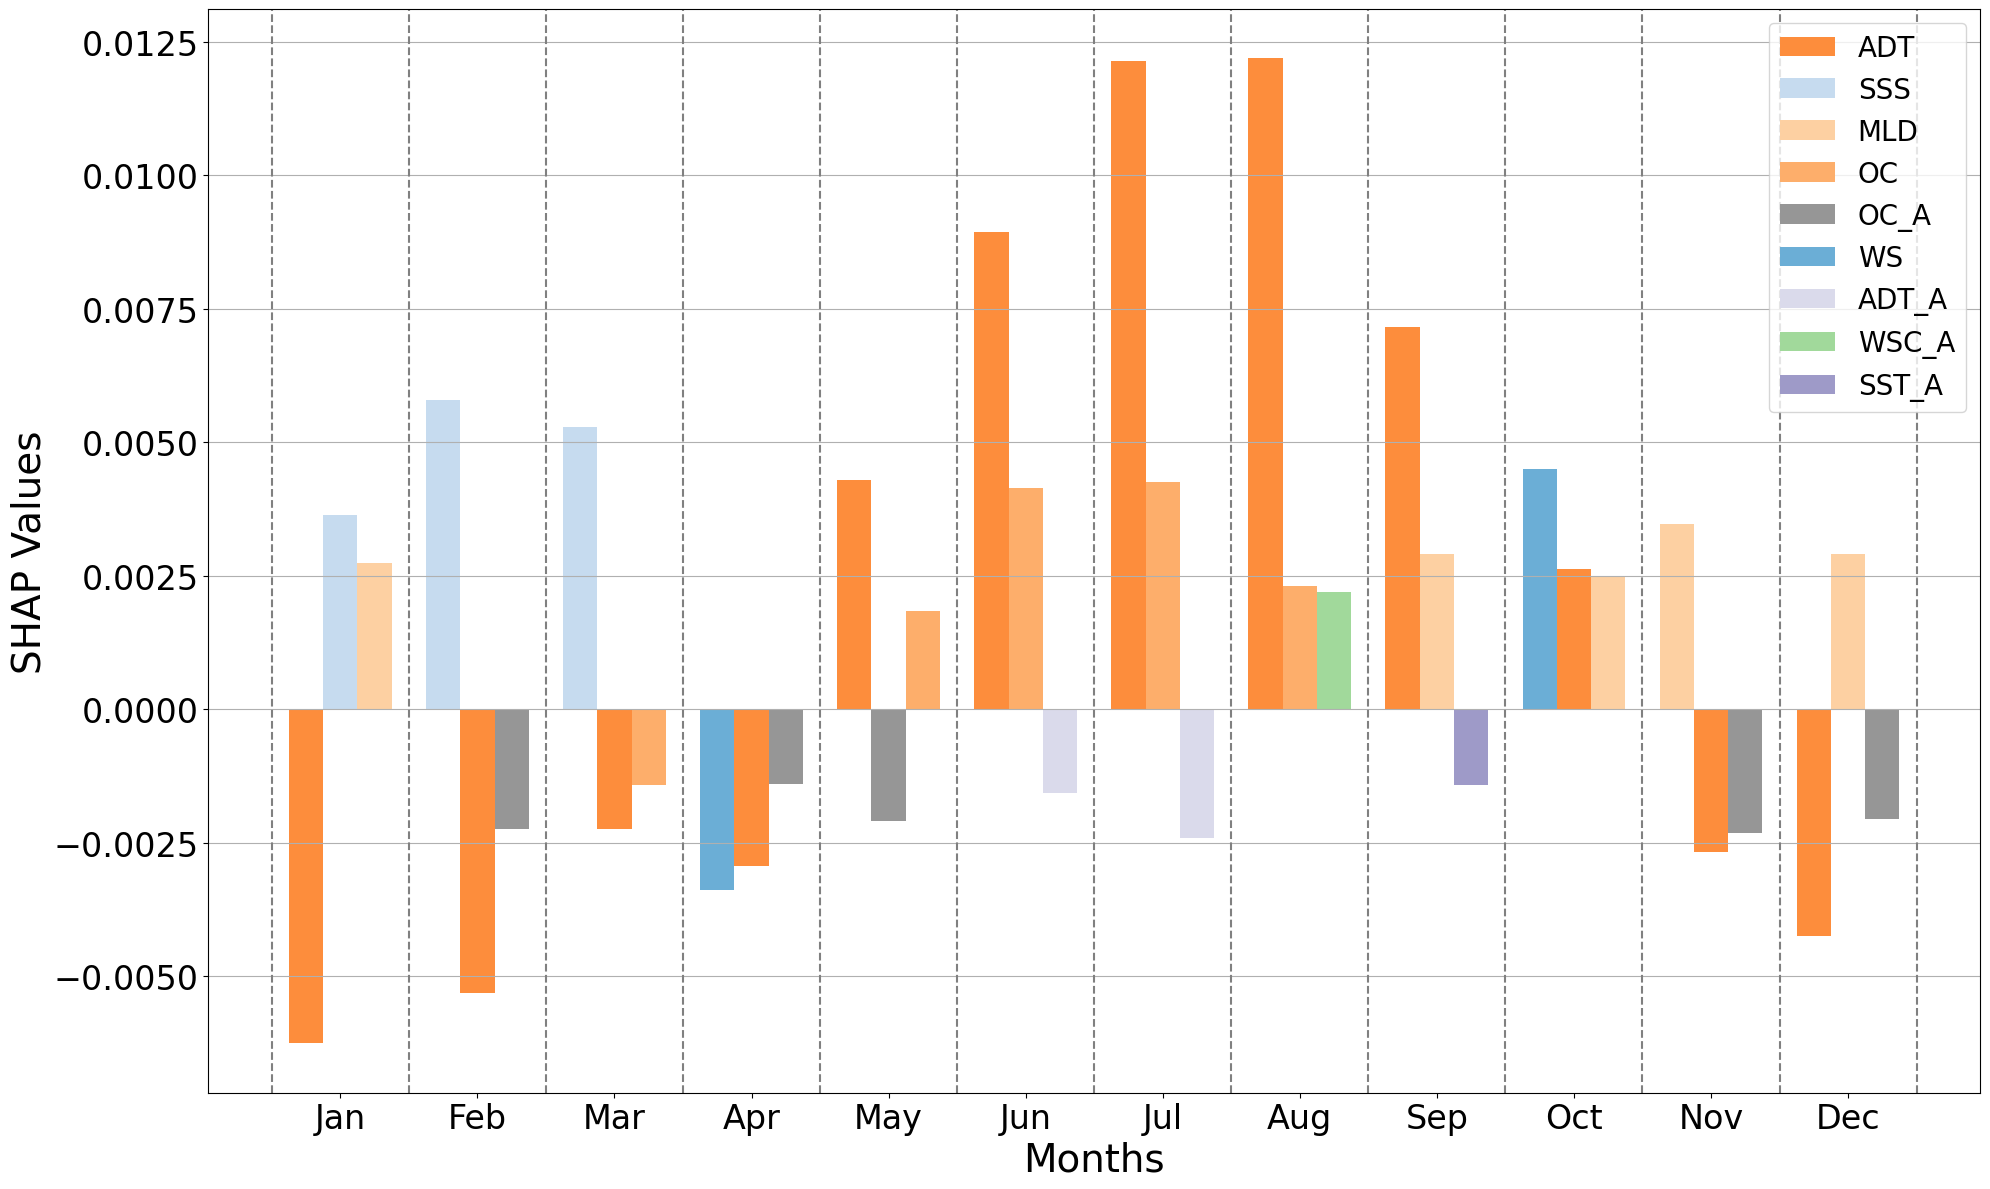

In [193]:
import calendar

# Get the colormap
cmap = plt.get_cmap('tab20c_r', len(var_list)) ## tab20_r, tab20c_r, 
color_mapping = {var: cmap(i) for i, var in enumerate(var_list)}

# Flatten the data for plotting
# Extract unique variables from all sets
all_variables = set().union(*common_variables)
variables = sorted(all_variables)
n_variables = len(variables)
months = range(1, 13)

# Prepare SHAP values matrix
shap_matrix = np.zeros((len(months), n_variables))

# Populate the SHAP values into the matrix
for month_idx, (var_set, shap_set) in enumerate(zip(common_variables, common_variables_shap_values)):
    for var in var_set:
        var_idx = variables.index(var)
        shap_matrix[month_idx, var_idx] = shap_set[var]

# Initialize a dictionary to store the sum of importance for each variable
importance_sums = {var: 0 for var in variables}


# Plotting
fig, ax = plt.subplots(figsize=(20, 12))

# Define bar width and positions
bar_width = 0.25
x = np.arange(len(months)+1)

# Track added labels
added_labels = set()

# Store offsets for x-ticks adjustment
offset_list = []

for month_idx in range(len(months)):

    # Extract the SHAP values and corresponding variables for the current month
    month_shap_values = shap_matrix[month_idx, :]
    non_zero_indices = np.where(month_shap_values != 0)[0]
    sorted_indices = non_zero_indices[np.argsort(np.abs(month_shap_values[non_zero_indices]))[::-1]]

    # Plot only the top 5 variables
    top_indices = sorted_indices[:3]
    
    offset = 0
    for var_idx in top_indices:
        var = variables[var_idx]
        label = var if var not in added_labels else ""
        ax.bar(month_idx + offset * bar_width, month_shap_values[var_idx], bar_width, label=label, color=color_mapping[var])
        if label:
            added_labels.add(var)

        # Accumulate the importance for sorting
        importance_sums[var] += abs(month_shap_values[var_idx])
        
        offset += 1

    offset_list.append(offset)

# Sort the variables based on the accumulated importance
sorted_variables = sorted(importance_sums, key=importance_sums.get, reverse=True)

# Update the legend to reflect the sorted order
handles, labels = ax.get_legend_handles_labels()
legend_mapping = {label: handle for label, handle in zip(labels, handles)}

sorted_handles = [legend_mapping[var] for var in sorted_variables if var in labels]
sorted_labels = [var for var in sorted_variables if var in labels]

ax.legend(sorted_handles, sorted_labels, loc='upper right', fontsize=20)


# Customize x-axis
calendar_months = list(calendar.month_name[1:])
short_names = [month[:3] for month in calendar_months]
ax.set_xticks(x[:-1] + bar_width * (np.array(offset_list) - 1) / 2) ### x[:-1] to only select 12 months
ax.set_xticklabels(short_names)
ax.set_xlabel('Months', fontsize = 28)
ax.set_ylabel('SHAP Values', fontsize = 28)
ax.tick_params(axis='both', which='major', labelsize=24)

# Add vertical lines after each month
for pos in x + bar_width * offset:
    ax.axvline(pos-1, color='gray', linestyle='--')

# Add grid for better readability
ax.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()